**Trees**

Utilizzeremo un decision tree di sklearn e successivamente una random forest dello stesso pacchetto

In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, log_loss, accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

plt.rcParams.update({
    'font.size': 14,          # Dimensione globale del testo
    'axes.titlesize': 18,     # Titolo degli assi
    'axes.labelsize': 14,     # Etichette degli assi
    'xtick.labelsize': 12,    # Etichette dei tick sull'asse x
    'ytick.labelsize': 12,    # Etichette dei tick sull'asse y
    'legend.fontsize': 14,    # Font delle leggende
    'figure.titlesize': 20    # Titolo generale della figura
})

In [303]:
dataPath = "C:\\Users\\giuse\\Downloads\\monk\\monks-"

def reading(trainset, testset):
    TrainingSet = pd.read_csv(trainset, sep='\s+', header=None)
    TestSet = pd.read_csv(testset, sep='\s+', header=None)

    # Split into features (X) and labels (y)
    x_train = TrainingSet.iloc[:, 1:-1]  # Features (excluding the first column)
    y_train = TrainingSet.iloc[:, 0]  # Labels (first column)
    x_test = TestSet.iloc[:, 1:-1]  # Features (excluding the first column)
    y_test = TestSet.iloc[:, 0]  # Labels (first column)
    return x_train, x_test, y_train, y_test

class monk:
    def __init__(self, FT, FTe, LT, LTe):
        self.featuresTrain = FT
        self.featuresTest = FTe
        self.labelTrain = LT
        self.labelTest = LTe

FT, FTe, LT, LTe = reading(dataPath + "1.train", dataPath + "1.test")
monk1 = monk(FT, FTe, LT, LTe)
FT, FTe, LT, LTe = reading(dataPath + "2.train", dataPath + "2.test")
monk2 = monk(FT, FTe, LT, LTe)
FT, FTe, LT, LTe = reading(dataPath + "3.train", dataPath + "3.test")
monk3 = monk(FT, FTe, LT, LTe)

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\giuse\AppData\Local\Temp\ipykernel_25416\166360033.py:4: SyntaxWarning: invalid escape sequence '\s'
  TrainingSet = pd.read_csv(trainset, sep='\s+', header=None)
C:\Users\giuse\AppData\Local\Temp\ipykernel_25416\166360033.py:5: SyntaxWarning: invalid escape sequence '\s'
  TestSet = pd.read_csv(testset, sep='\s+', header=None)


Scelta ordine grandezza dei parametri:

nei train sono presenti ~500 sample --> applicando la 5-fold-CV il validation set avrà ~100 sample.

Date le dimensioni nodi = log2(100)-2 (non vogliamo foglie con meno di 4 elementi o l'algoritmo starebbe "ricordando")
quindi nodi = 4.6 --> non ha senso inserire più di 5 nodi, per sicurezza inseriamo None nella griglia.
quindi come numero minimo di campioni per foglia inseriamo 4, se la profondità è minore possiamo aumentarlo e di
conseguenza dovremo inserire 8 come numero minimo di split

In [304]:
parameters = {
    'max_depth': [2, 4, 5, None],                   # Numero di nodi
    'min_samples_split': [8],                       # Numero minimo di campioni per splittare un nodo
    'min_samples_leaf': [4],                        # Numero minimo di campioni per foglia
    'criterion': ['gini', 'entropy', 'log_loss'],    # Funzione per misurare la qualità di uno split
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
    }

tree = DecisionTreeClassifier(random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

score = ['f1', 'accuracy', 'precision', 'recall', 'roc_auc', 'balanced_accuracy']

treeMonk1 = GridSearchCV(tree, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
treeMonk2 = GridSearchCV(tree, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
treeMonk3 = GridSearchCV(tree, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')

treeMonk1.fit(monk1.featuresTrain, monk1.labelTrain)
treeMonk2.fit(monk2.featuresTrain, monk2.labelTrain)
treeMonk3.fit(monk3.featuresTrain, monk3.labelTrain)

print(f"Monk1 best parameters: {treeMonk1.best_params_}")
print(f"Monk2 best parameters: {treeMonk2.best_params_}")
print(f"Monk3 best parameters: {treeMonk3.best_params_}")

Monk1 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8}
Monk2 best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8}
Monk3 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8}


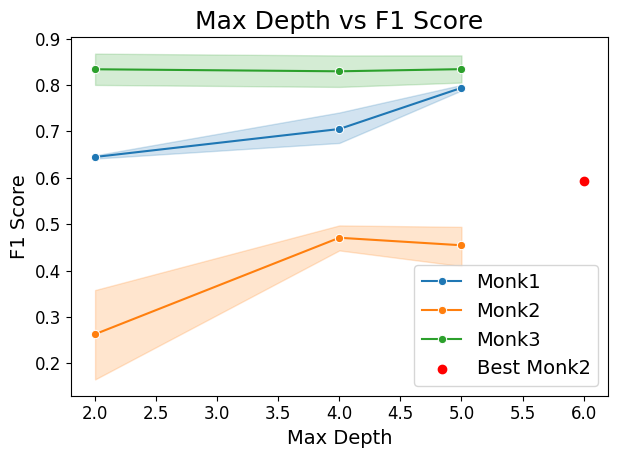

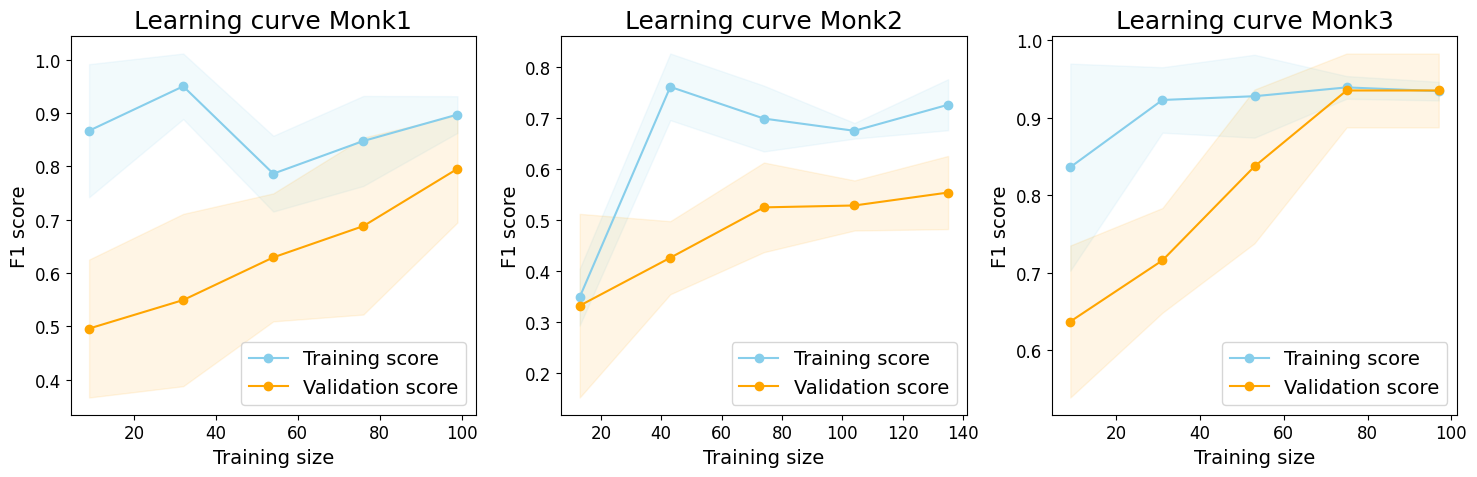

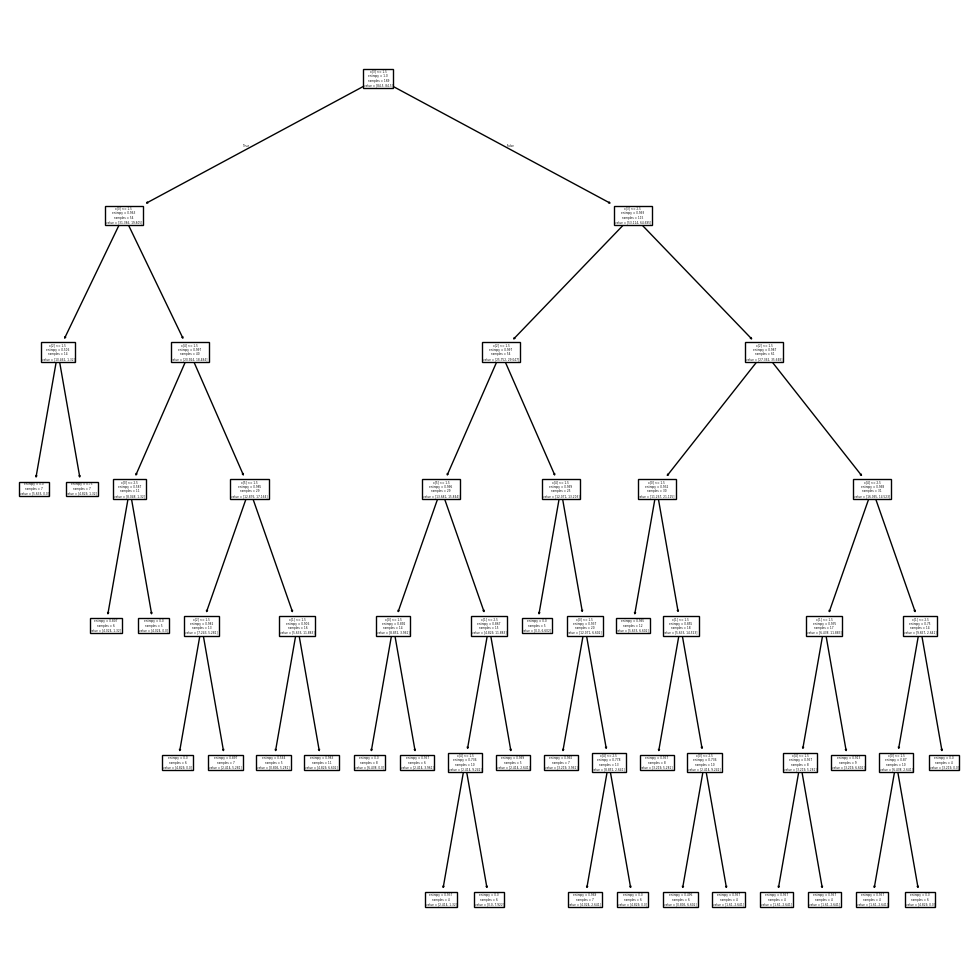

In [305]:
sns.lineplot(data=pd.DataFrame(treeMonk1.cv_results_), x='param_max_depth', y='mean_test_f1', label='Monk1', marker='o')
sns.lineplot(data=pd.DataFrame(treeMonk2.cv_results_), x='param_max_depth', y='mean_test_f1', label='Monk2', marker='o')
sns.lineplot(data=pd.DataFrame(treeMonk3.cv_results_), x='param_max_depth', y='mean_test_f1', label='Monk3', marker='o')
plt.scatter(treeMonk2.best_estimator_.get_depth(), treeMonk2.best_score_, color='red', label='Best Monk2')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.title('Max Depth vs F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

fig0, ax0 = plt.subplots(1, 3, figsize=(15, 5))
train_sizes, train_scores, val_scores = learning_curve(treeMonk1.best_estimator_,
                                            monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

# Plot delle learning curve
ax0[0].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax0[0].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax0[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax0[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax0[0].set_title('Learning curve Monk1')
ax0[0].set_xlabel('Training size')
ax0[0].set_ylabel('F1 score')
ax0[0].legend(loc='lower right')
train_sizes, train_scores, val_scores = learning_curve(treeMonk2.best_estimator_,
                                            monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

ax0[1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax0[1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax0[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax0[1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax0[1].set_title('Learning curve Monk2')
ax0[1].set_xlabel('Training size')
ax0[1].set_ylabel('F1 score')
ax0[1].legend()
train_sizes, train_scores, val_scores = learning_curve(treeMonk3.best_estimator_,
                                            monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax0[2].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax0[2].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax0[2].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax0[2].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax0[2].set_title('Learning curve Monk3')
ax0[2].set_xlabel('Training size')
ax0[2].set_ylabel('F1 score')
ax0[2].legend()
plt.tight_layout()
plt.show()

tree2Fig = plt.figure(figsize=(10, 10))
plot_tree(treeMonk2.best_estimator_)
plt.tight_layout()
plt.show()

Lo score medio sui 5-fold  e il grafico della learning curve del monk1 e del monk3 fanno pensare che i parametri vadano bene.

Sul monk2 (0.592), {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 8} i grafici fanno pensare all'overfitting quindi proviamo un'operazione di potatura.

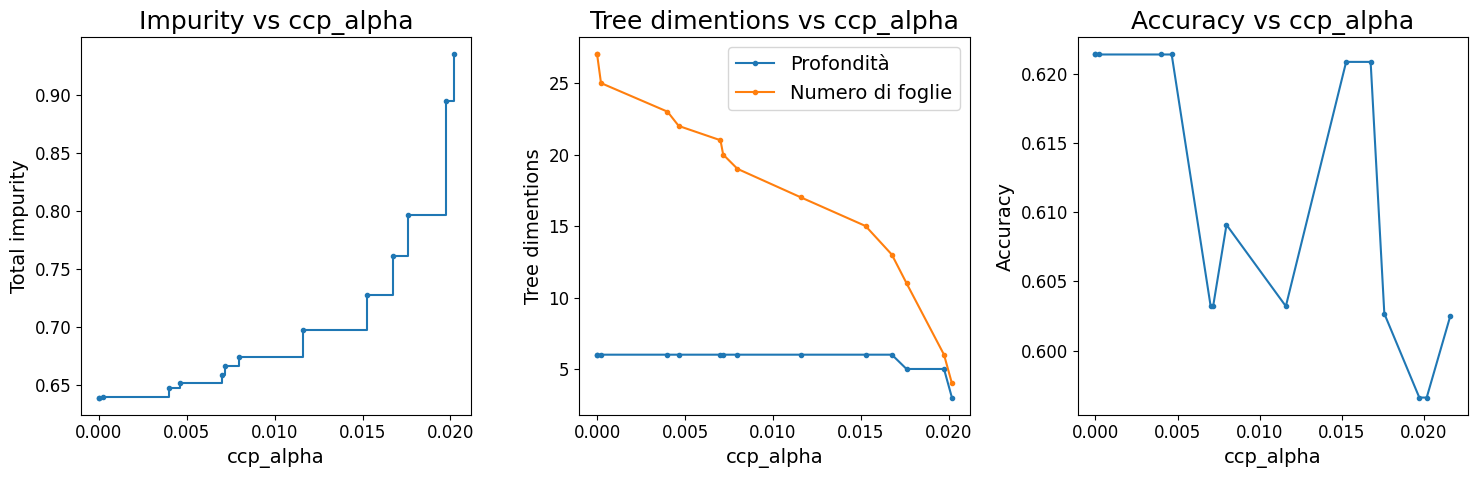

In [306]:
path = treeMonk2.best_estimator_.cost_complexity_pruning_path(monk2.featuresTrain, monk2.labelTrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Costruisci alberi con diversi valori di ccp_alpha
models = []
aScore = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, **treeMonk2.best_params_)
    tree.fit(monk2.featuresTrain, monk2.labelTrain)
    aScore.append(np.mean(cross_val_score(tree, monk2.featuresTrain, monk2.labelTrain, cv=skf)))
    models.append(tree)

# Trova la dimensione dell'albero (numero di foglie e profondità) per ogni alpha
depths = [tree.get_depth() for tree in models]
leaves = [tree.get_n_leaves() for tree in models]

# ccp_alphas = ccp_alphas*100

# Visualizza l'andamento delle impurità in base a ccp_alpha
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ccp_alphas[:-1], impurities[:-1], marker='.', drawstyle="steps-post")
ax[0].set_xlabel("ccp_alpha")
ax[0].set_ylabel("Total impurity")
ax[0].set_title("Impurity vs ccp_alpha")

ax[1].plot(ccp_alphas[:-1], depths[:-1], marker='.', label="Profondità")
ax[1].plot(ccp_alphas[:-1], leaves[:-1], marker='.', label="Numero di foglie")
ax[1].set_xlabel("ccp_alpha")
ax[1].set_ylabel("Tree dimentions")
ax[1].set_title("Tree dimentions vs ccp_alpha")
ax[1].legend()

ax[2].plot(ccp_alphas, aScore, marker='.')
ax[2].set_xlabel("ccp_alpha")
ax[2].set_ylabel("Accuracy")
ax[2].set_title("Accuracy vs ccp_alpha")
plt.tight_layout()
plt.show()

Monk2 best parameters: {'ccp_alpha': np.float64(0.01526789473683248), 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
Monk 1 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8}
Monk 3 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8}


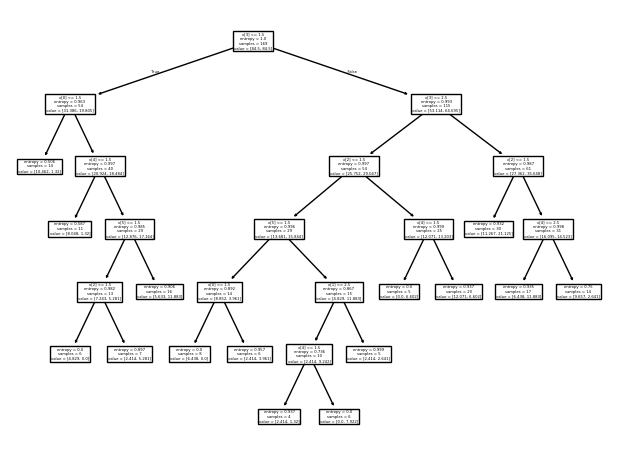

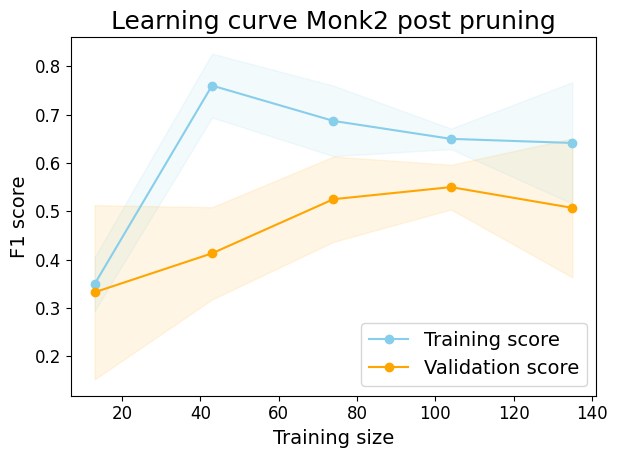

In [307]:
# ccp = np.argmax(aScore)
ccp = 9 # 0.015 in quanto riduce il numero di foglie senza diminuire significativamente l'accuratezza e senza aumentare l'impurità
param_grid2 = models[ccp].get_params()
# param_grid2['ccp_alpha'] = ccp_alphas[ccp]
treeMonk2 = DecisionTreeClassifier(**param_grid2)
print(f"Monk2 best parameters: {treeMonk2.get_params()}")
print(f"Monk 1 best parameters: {treeMonk1.best_params_}")
print(f"Monk 3 best parameters: {treeMonk3.best_params_}")
# treeMonk2 = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alphas[4], **treeMonk2.best_params_)
treeMonk2.fit(monk2.featuresTrain, monk2.labelTrain)
np.mean(cross_val_score(treeMonk2, monk2.featuresTrain, monk2.labelTrain, cv=skf))

plot_tree(treeMonk2)
plt.tight_layout()
plt.show()


train_sizes, train_scores, val_scores = learning_curve(treeMonk2,
                                            monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
plt.plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
plt.plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
plt.title('Learning curve Monk2 post pruning')
plt.xlabel('Training size')
plt.ylabel('F1 score')
plt.legend()
plt.tight_layout()
plt.show()

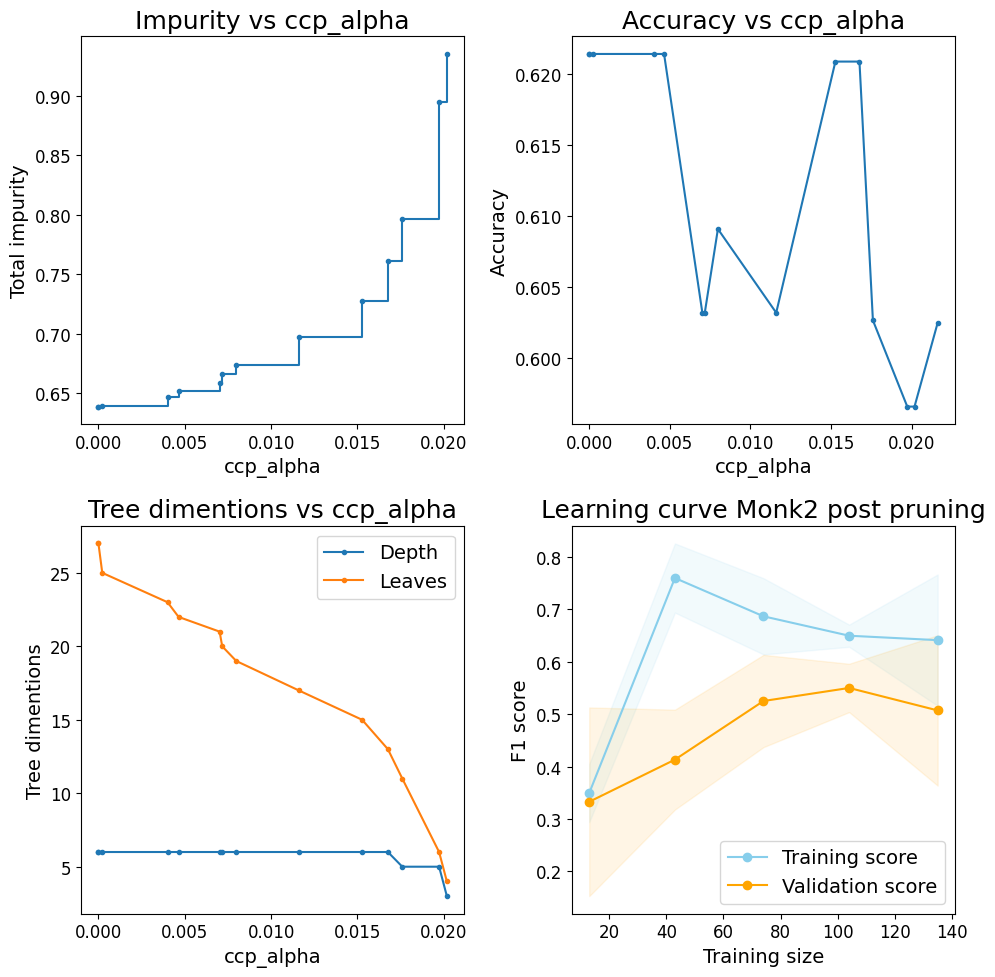

In [308]:
figr, axr = plt.subplots(2, 2, figsize=(10, 10))
axr[0,0].plot(ccp_alphas[:-1], impurities[:-1], marker='.', drawstyle="steps-post")
axr[0,0].set_xlabel("ccp_alpha")
axr[0,0].set_ylabel("Total impurity")
axr[0,0].set_title("Impurity vs ccp_alpha")

axr[1,0].plot(ccp_alphas[:-1], depths[:-1], marker='.', label="Depth")
axr[1,0].plot(ccp_alphas[:-1], leaves[:-1], marker='.', label="Leaves")
axr[1,0].set_xlabel("ccp_alpha")
axr[1,0].set_ylabel("Tree dimentions")
axr[1,0].set_title("Tree dimentions vs ccp_alpha")
axr[1,0].legend()

axr[0,1].plot(ccp_alphas, aScore, marker='.')
axr[0,1].set_xlabel("ccp_alpha")
axr[0,1].set_ylabel("Accuracy")
axr[0,1].set_title("Accuracy vs ccp_alpha")
axr[1, 1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
axr[1, 1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
axr[1, 1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
axr[1, 1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
axr[1, 1].set_title('Learning curve Monk2 post pruning')
axr[1, 1].set_xlabel('Training size')
axr[1, 1].set_ylabel('F1 score')
axr[1, 1].legend()
plt.tight_layout()
plt.show()

Sembra essere migliorato quindi procediamo testando i modelli

Decision Tree
Monk-1 F1-score: 0.8421052631578947
Monk-2 F1-score: 0.6157407407407407
Monk-3 F1-score: 0.972972972972973


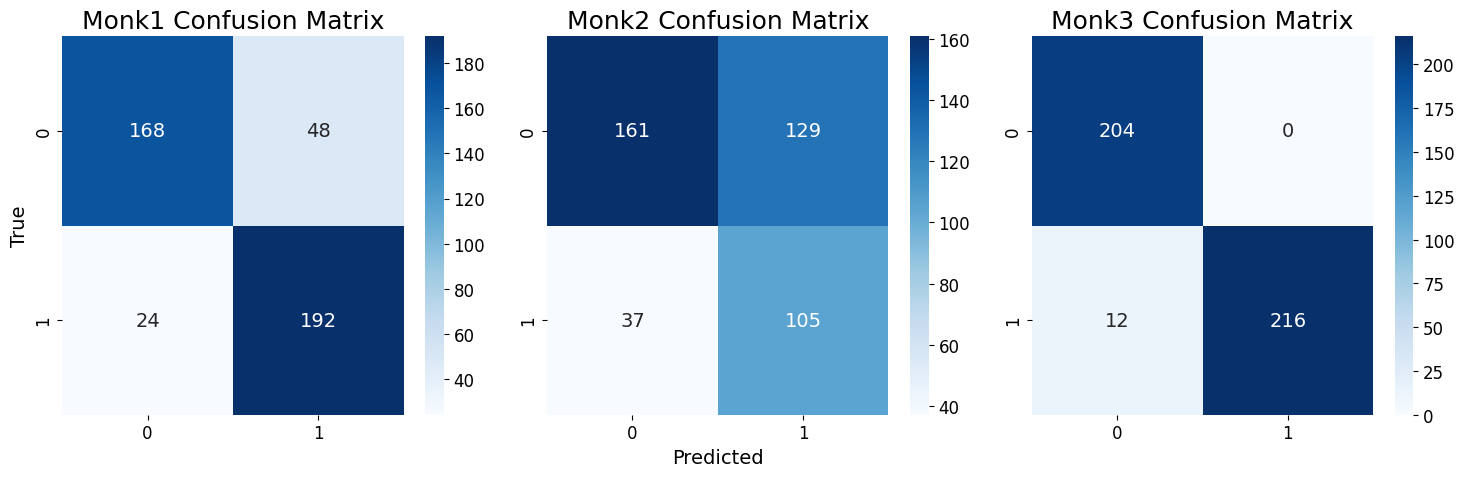

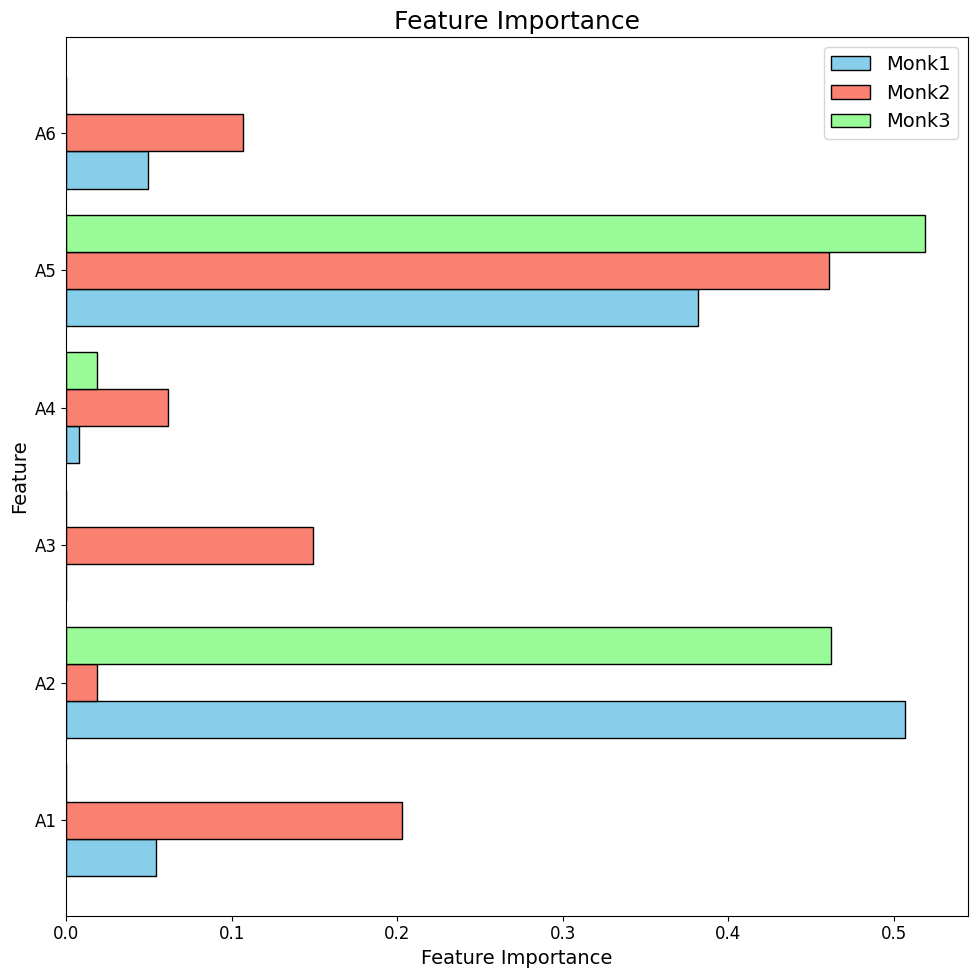

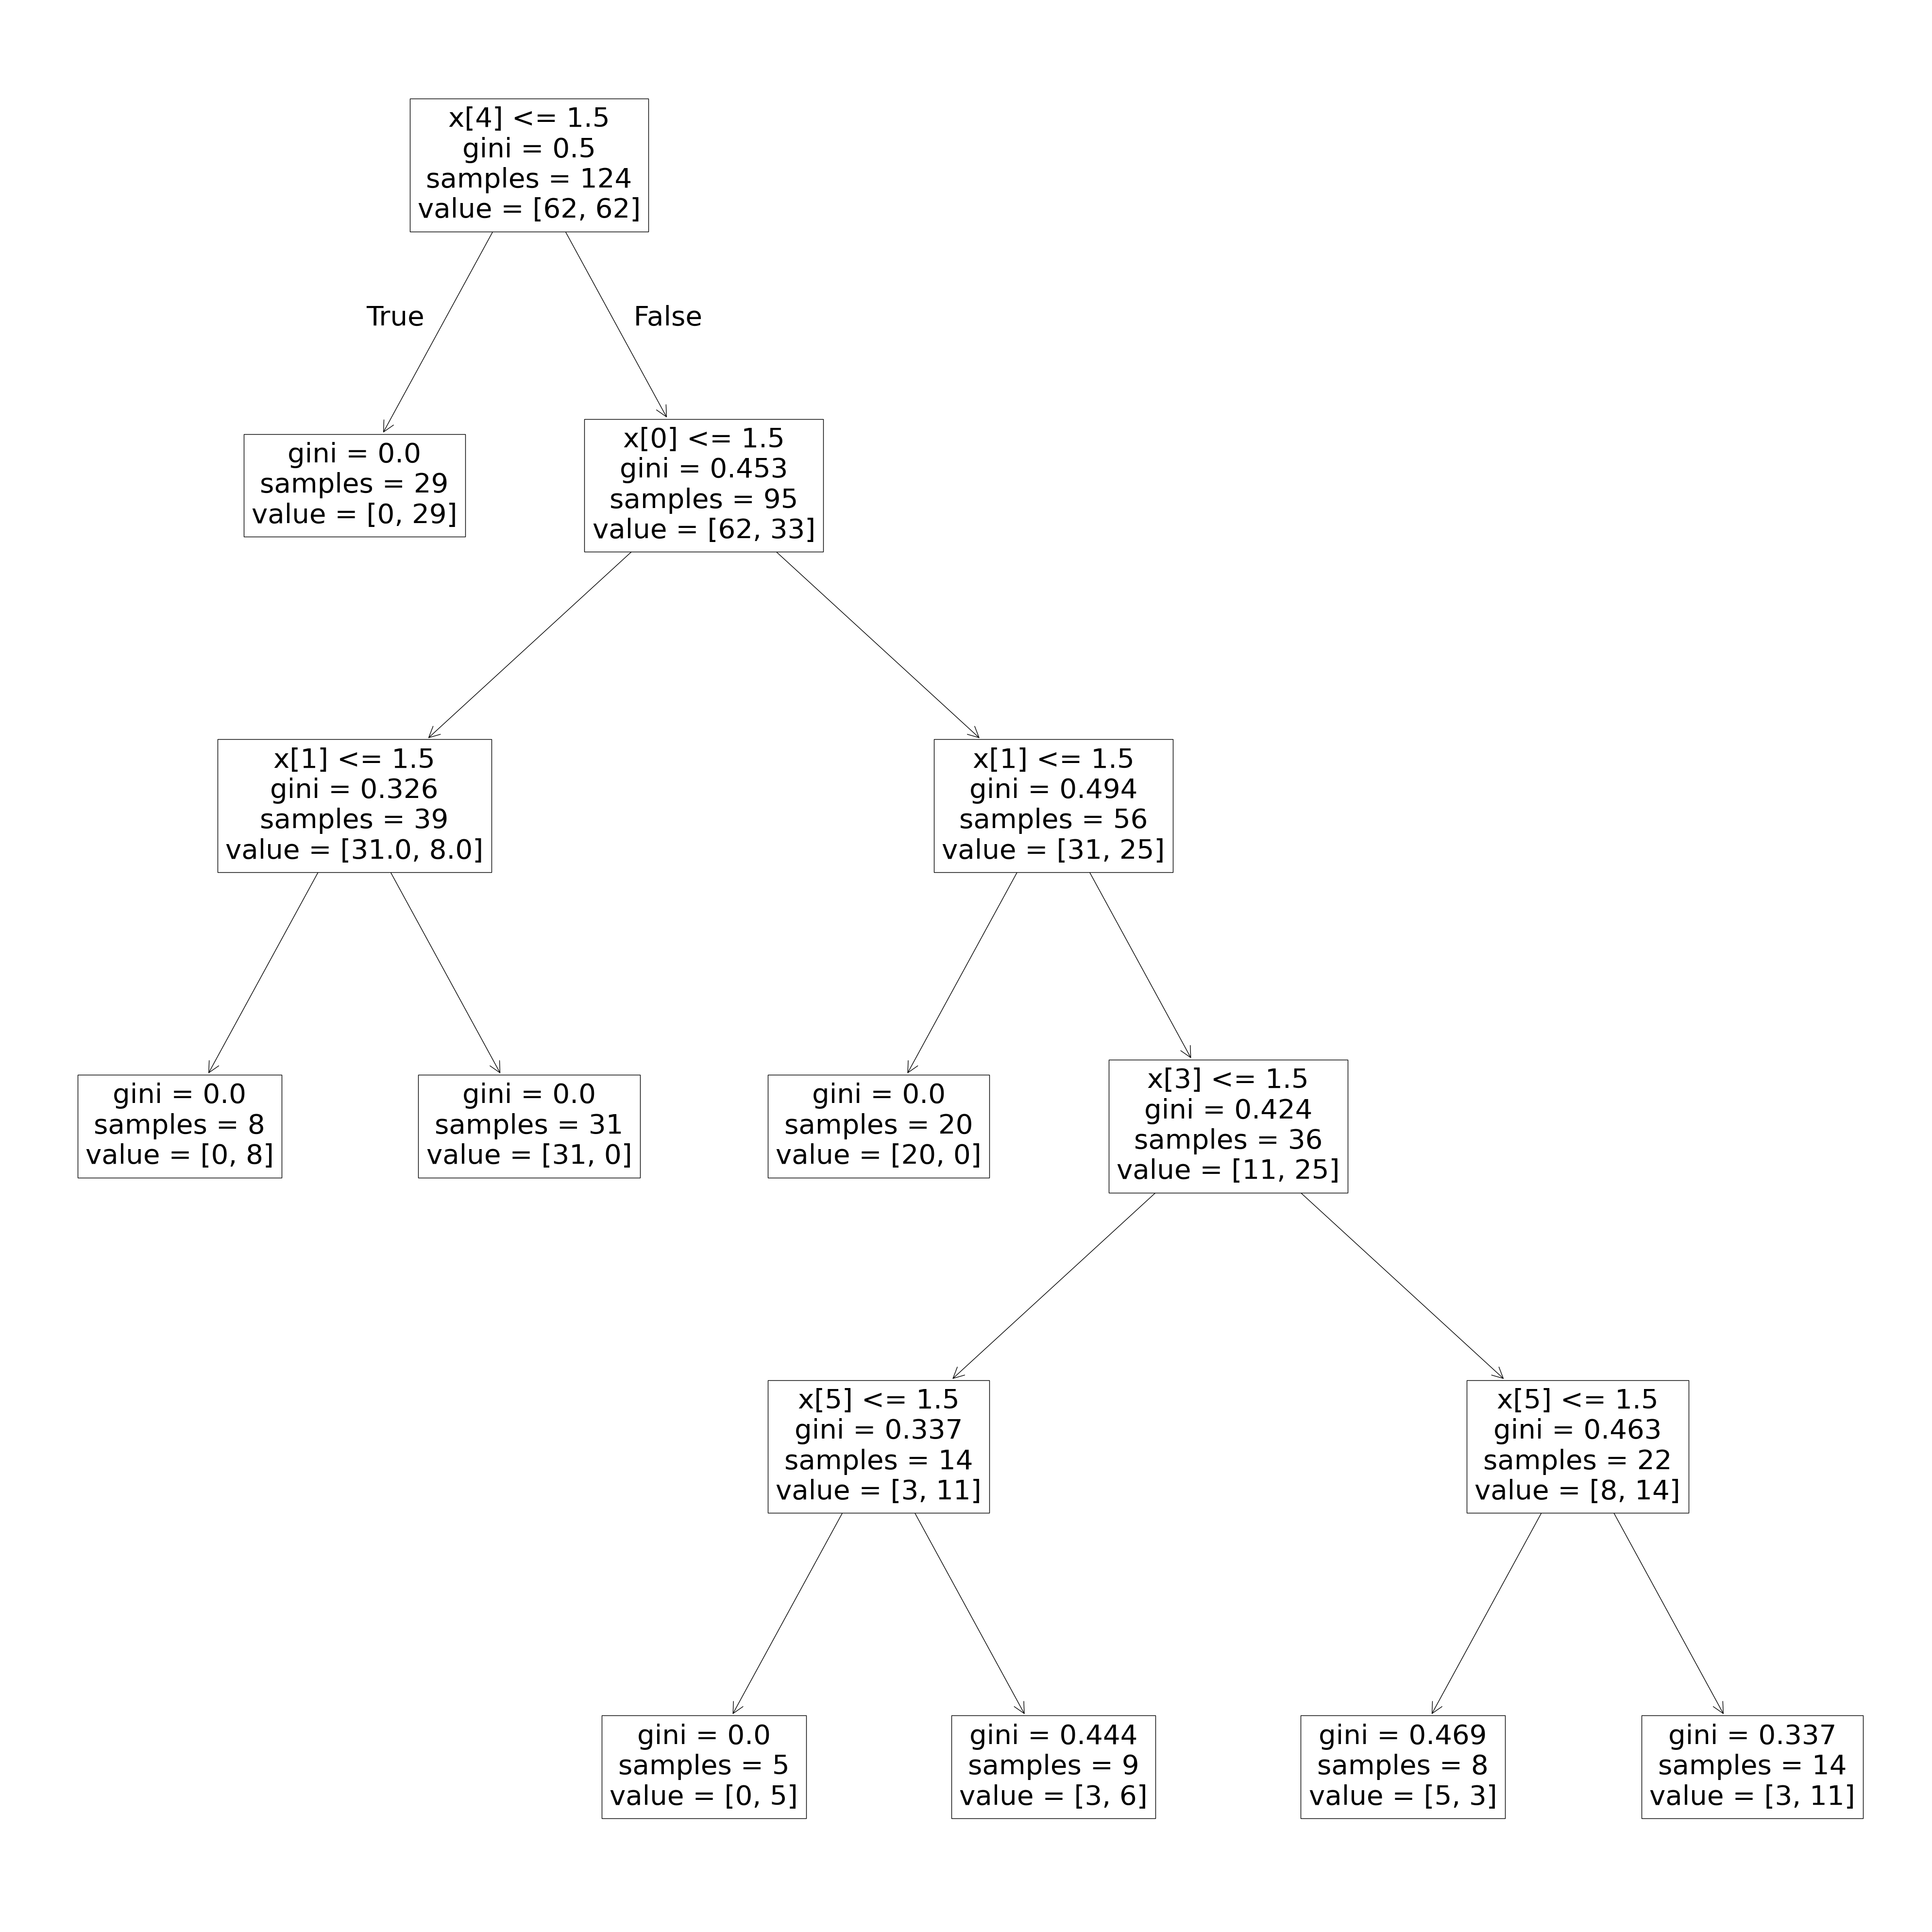

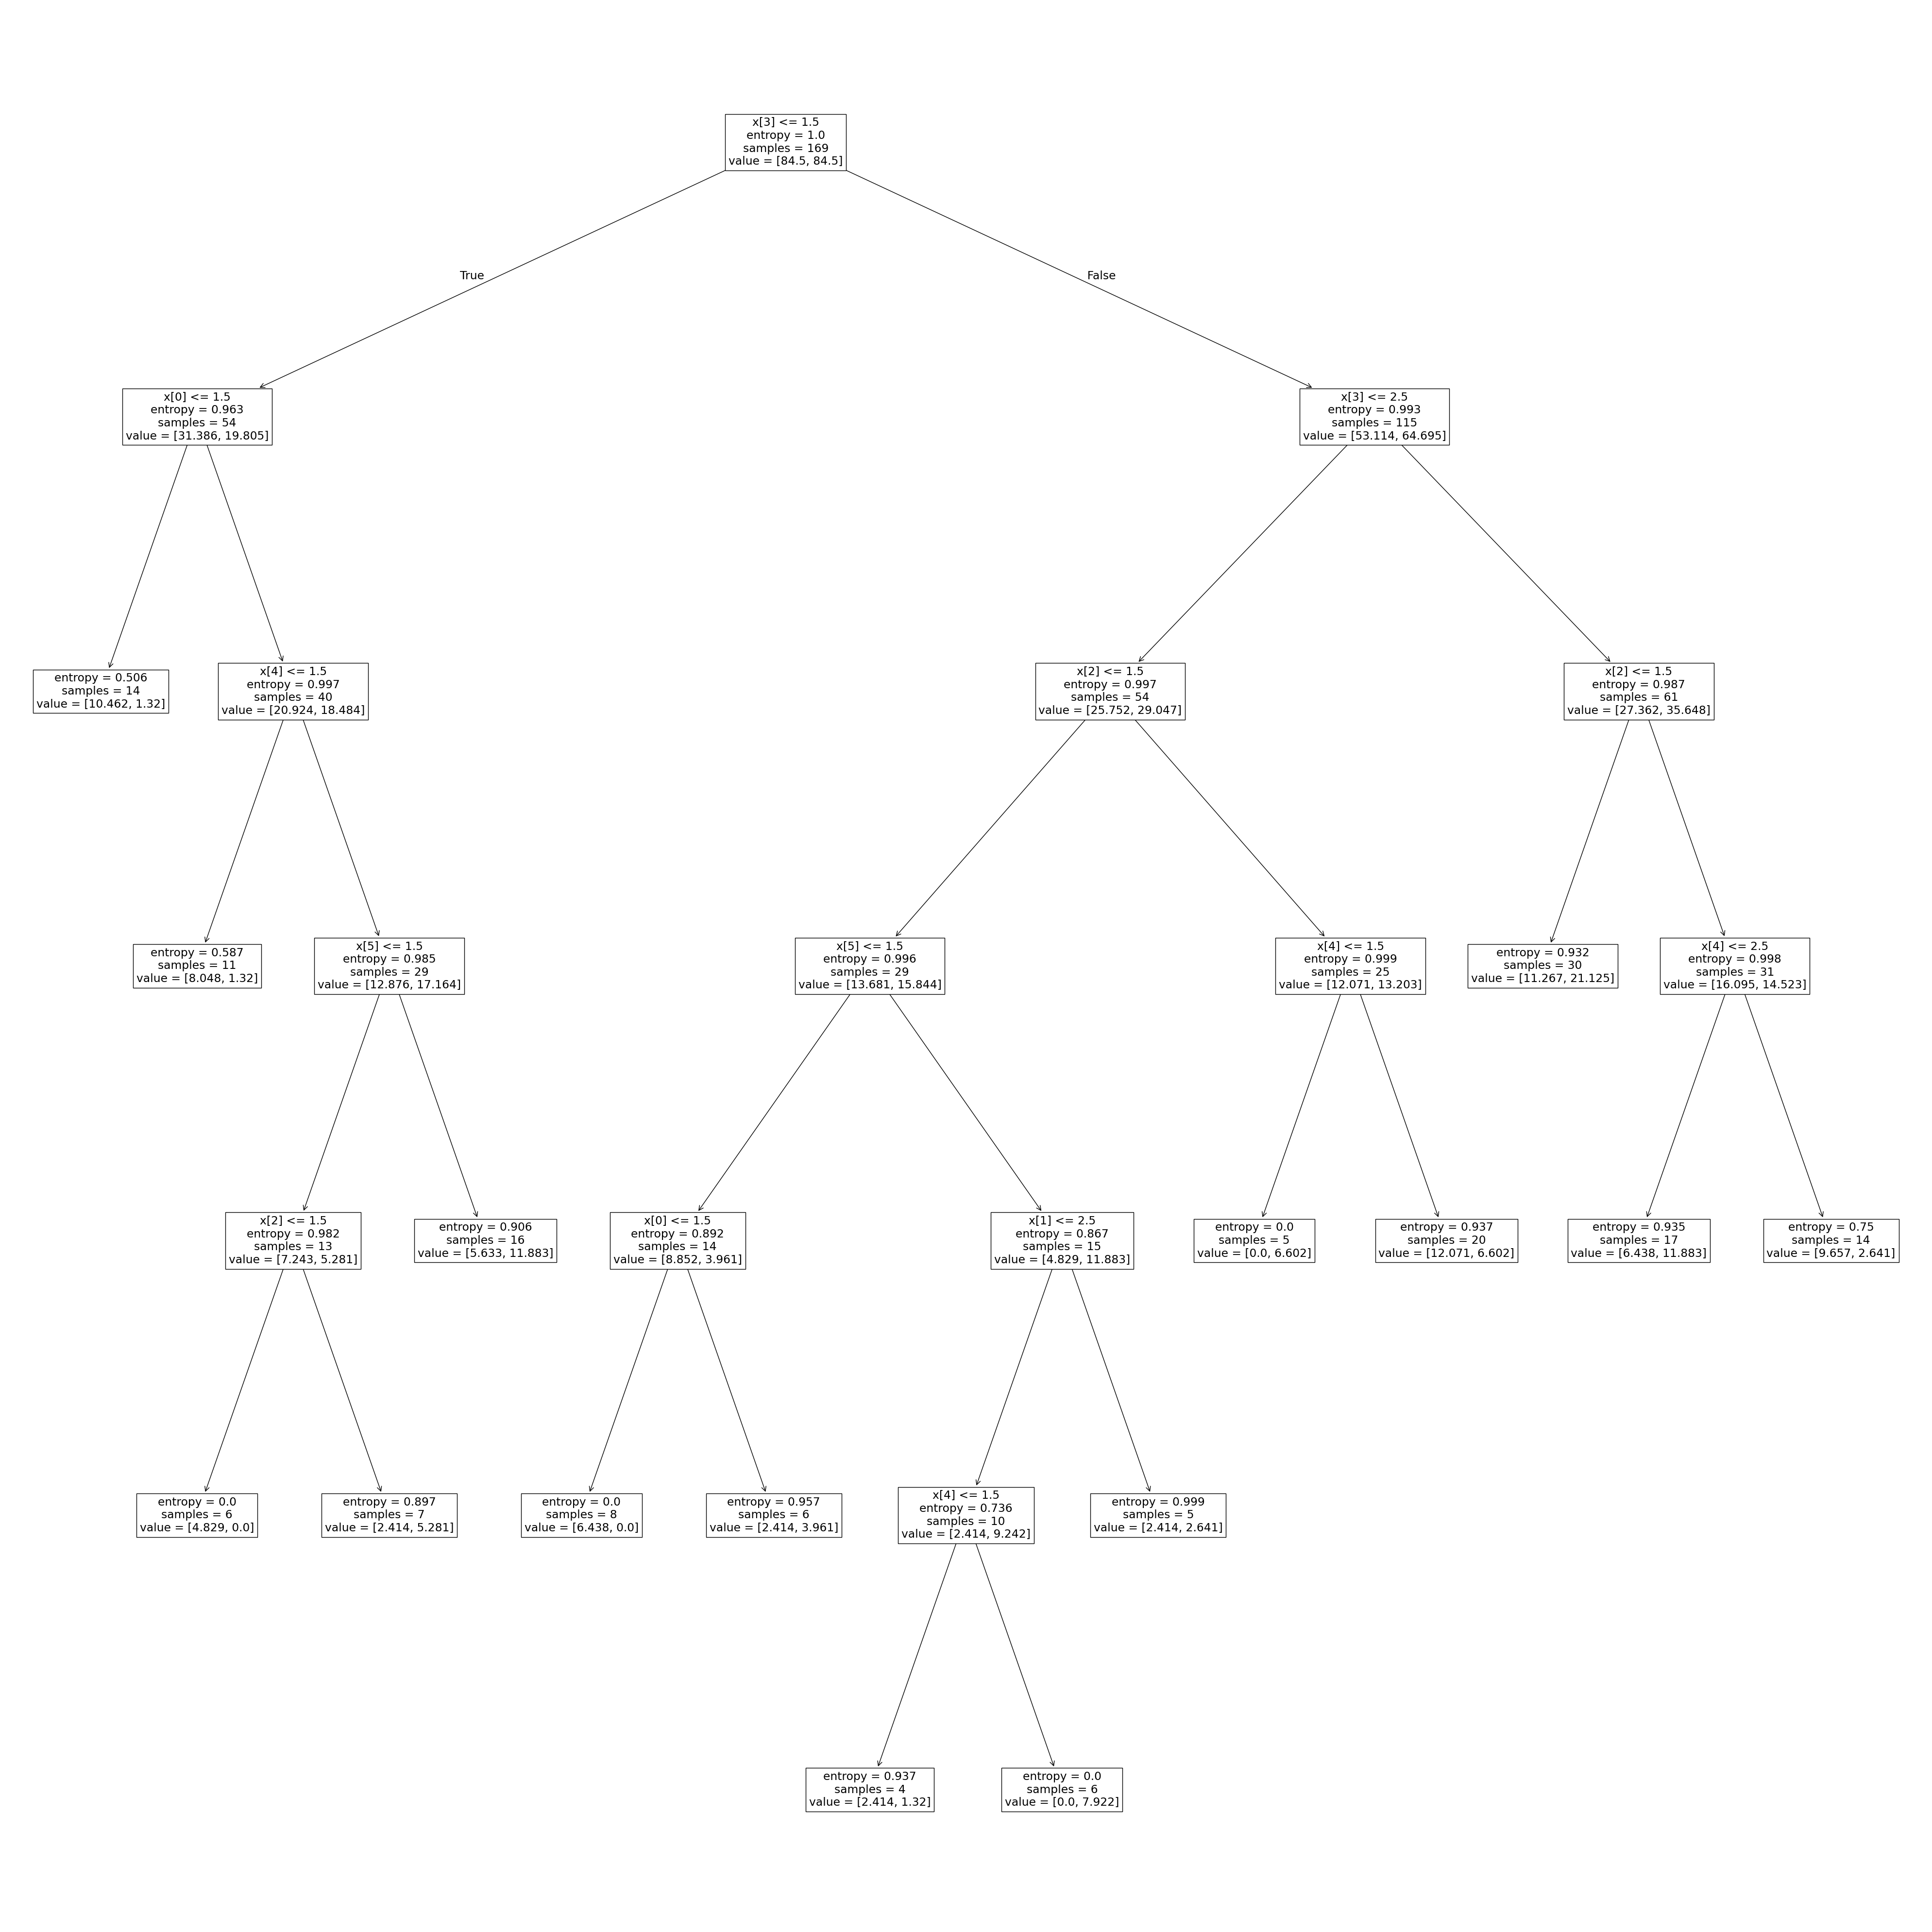

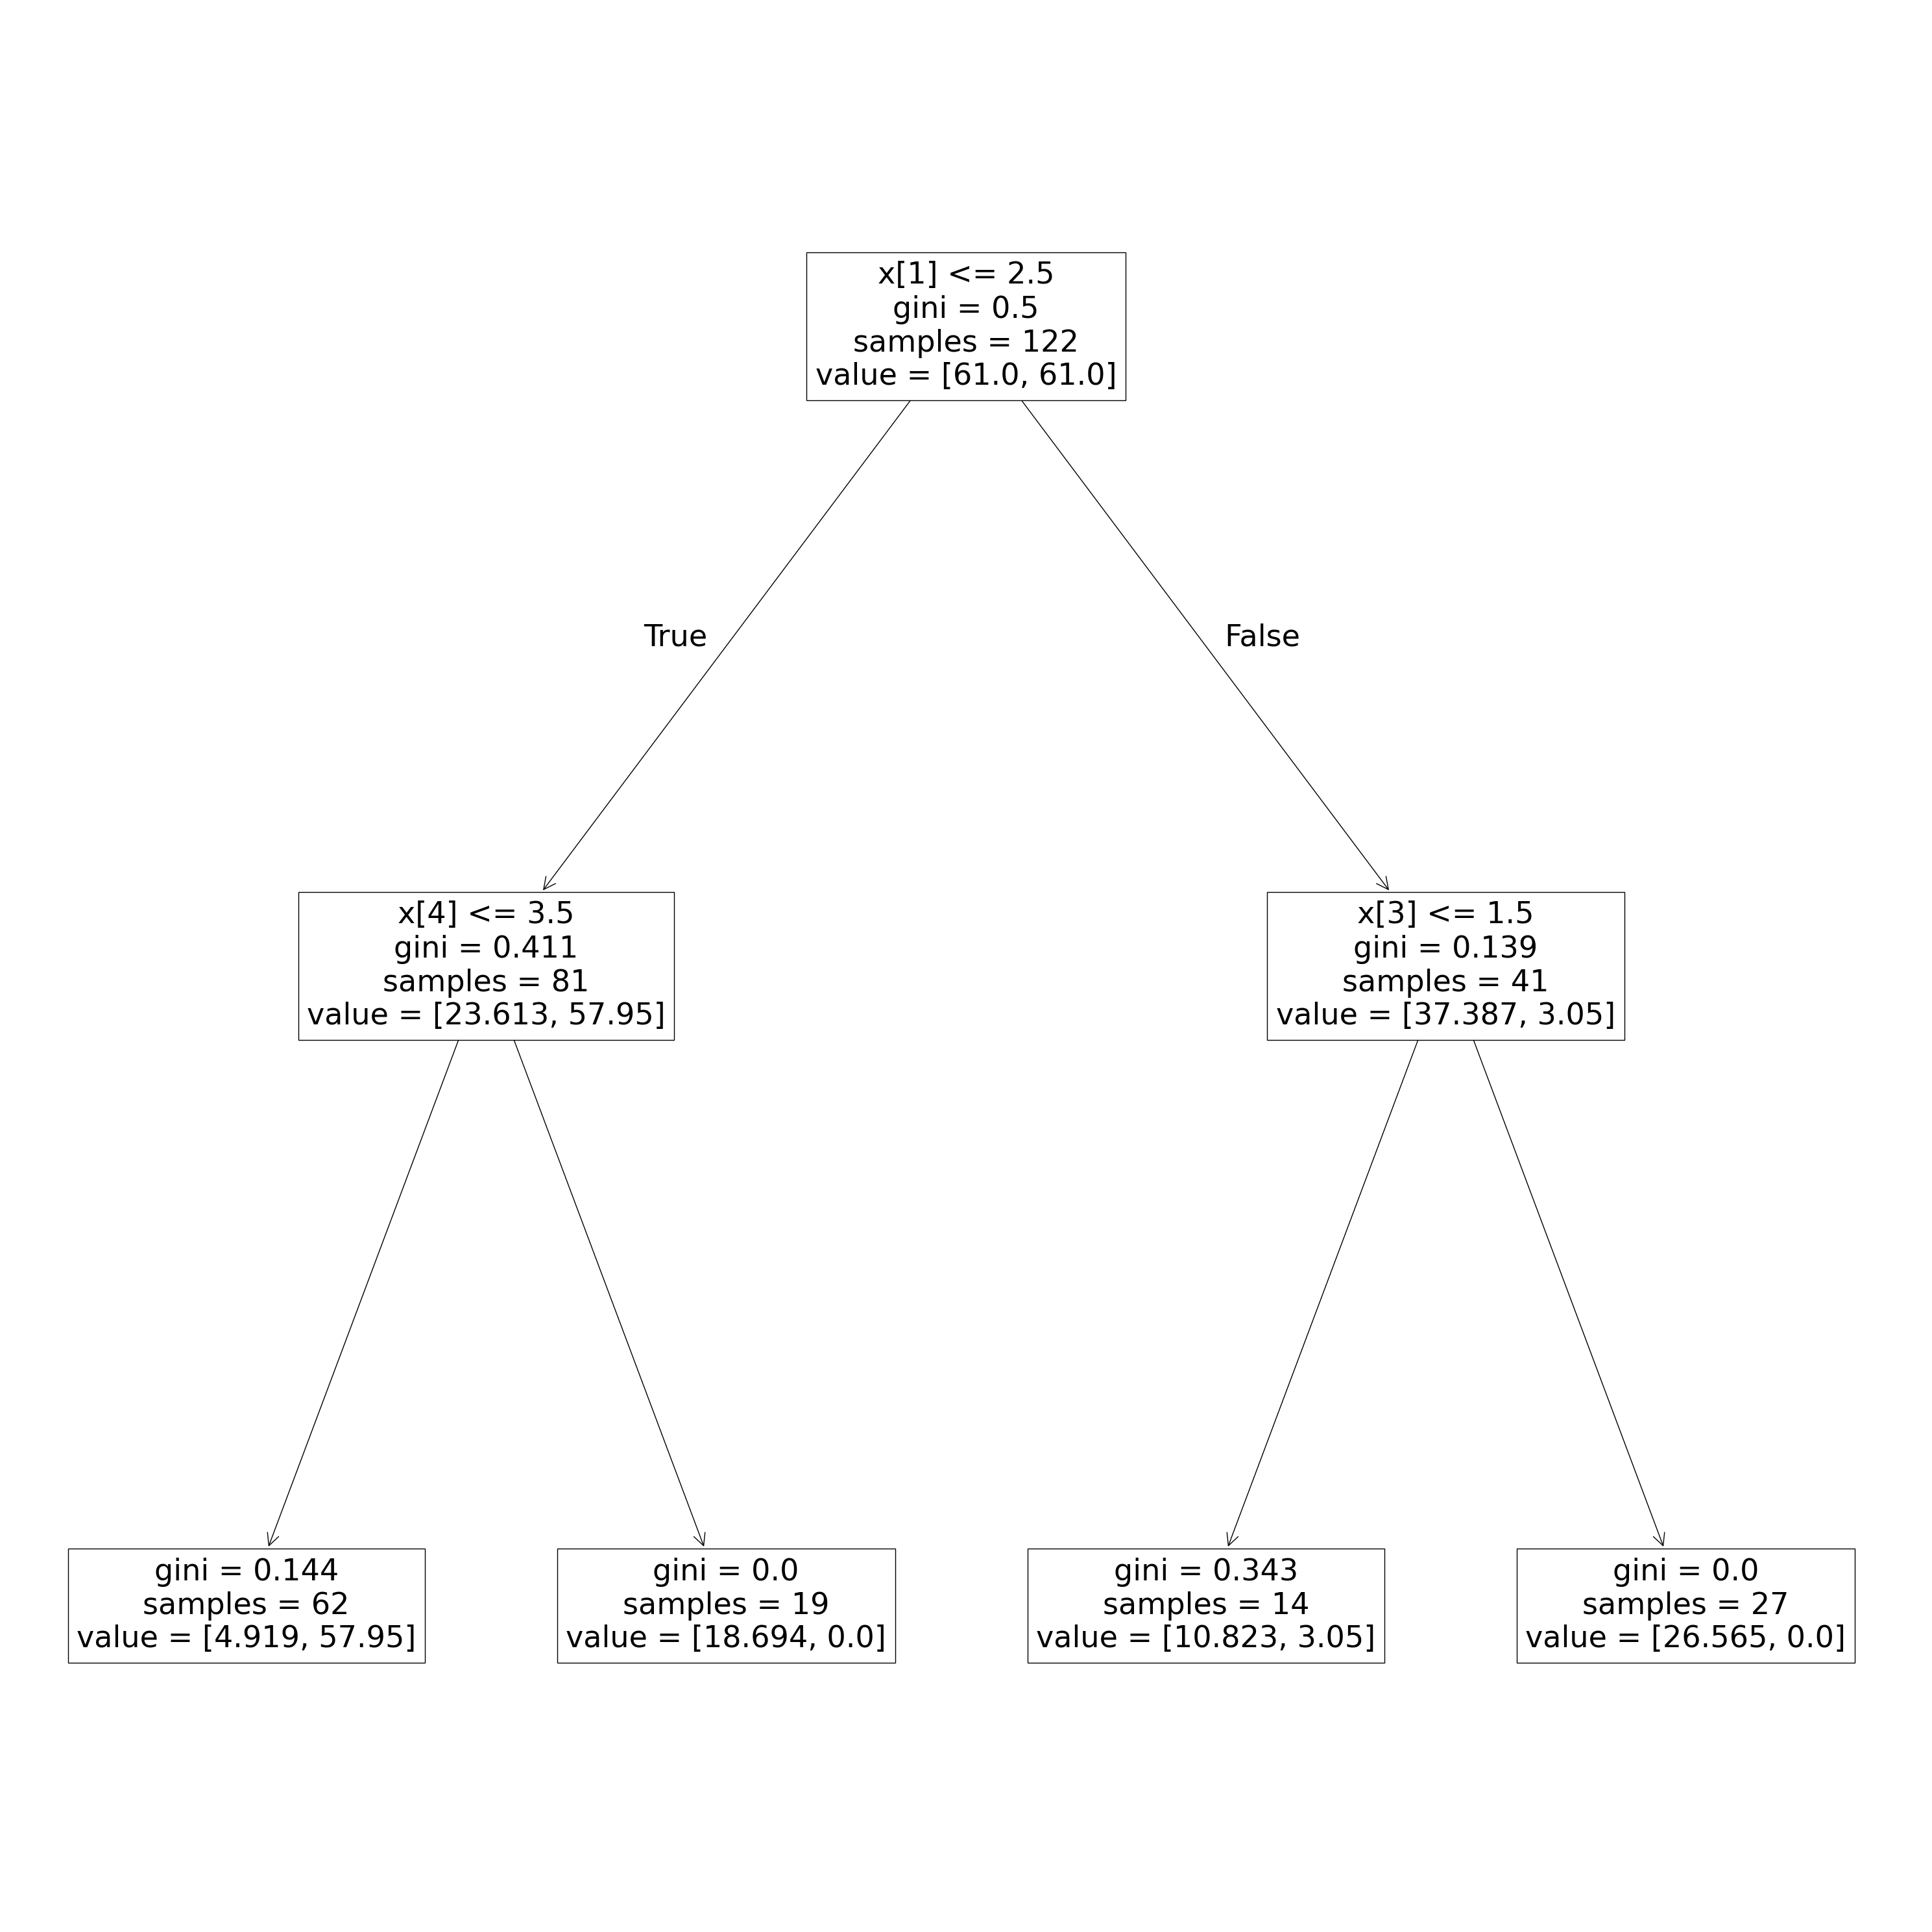

In [309]:
treeMonk1Score = treeMonk1.score(monk1.featuresTest, monk1.labelTest)
treeMonk2Score = treeMonk2.score(monk2.featuresTest, monk2.labelTest)
treeMonk3Score = treeMonk3.score(monk3.featuresTest, monk3.labelTest)

print("Decision Tree")
print(f"Monk-1 F1-score: {treeMonk1Score}")
print(f"Monk-2 F1-score: {treeMonk2Score}")
print(f"Monk-3 F1-score: {treeMonk3Score}")

fig1, ax1 = plt.subplots(1, 3, figsize=(15, 5))
confMatrixMonk1 = confusion_matrix(monk1.labelTest, treeMonk1.predict(monk1.featuresTest))
confMatrixMonk2 = confusion_matrix(monk2.labelTest, treeMonk2.predict(monk2.featuresTest))
confMatrixMonk3 = confusion_matrix(monk3.labelTest, treeMonk3.predict(monk3.featuresTest))
sns.heatmap(confMatrixMonk1, annot=True, fmt="d", cmap="Blues", ax=ax1[0])
sns.heatmap(confMatrixMonk2, annot=True, fmt="d", cmap="Blues", ax=ax1[1])
sns.heatmap(confMatrixMonk3, annot=True, fmt="d", cmap="Blues", ax=ax1[2])
ax1[0].set_title('Monk1 Confusion Matrix')
ax1[1].set_title('Monk2 Confusion Matrix')
ax1[2].set_title('Monk3 Confusion Matrix')
ax1[0].set(ylabel="True")
ax1[1].set(xlabel="Predicted")
plt.tight_layout()
plt.show()

monk1Feat = treeMonk1.best_estimator_.feature_importances_
monk2Feat = treeMonk2.feature_importances_
monk3Feat = treeMonk3.best_estimator_.feature_importances_

x = np.arange(6)
width = 0.27

plt.figure(figsize=(10, 10))
plt.barh(x - width, monk1Feat, height=width, label='Monk1', color='skyblue', edgecolor='black')
plt.barh(x, monk2Feat, height=width, label="Monk2", color='salmon', edgecolor='black')
plt.barh(x + width, monk3Feat, height=width, label="Monk3", color='palegreen', edgecolor='black')
plt.yticks(x, ['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.legend()
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

tree1Fig = plt.figure(figsize=(40, 40))
plot_tree(treeMonk1.best_estimator_)
plt.tight_layout()
plt.show()
tree2Fig = plt.figure(figsize=(40, 40))
# plot_tree(treeMonk2.best_estimator_)
plot_tree(treeMonk2)
plt.tight_layout()
plt.show()
tree3Fig = plt.figure(figsize=(30, 30))
plot_tree(treeMonk3.best_estimator_)
plt.tight_layout()
plt.show()

I monk 1 e 3 hanno degli ottimi risultati, il monk 2 invece tende a classificare gli 0 come 1.

Procediamo plottando la roc-curve e stampando il classification report e gli altri score.

Classification Report Monk1
              precision    recall  f1-score   support

           0       0.88      0.78      0.82       216
           1       0.80      0.89      0.84       216

    accuracy                           0.83       432
   macro avg       0.84      0.83      0.83       432
weighted avg       0.84      0.83      0.83       432

Classification Report Monk2
              precision    recall  f1-score   support

           0       0.81      0.56      0.66       290
           1       0.45      0.74      0.56       142

    accuracy                           0.62       432
   macro avg       0.63      0.65      0.61       432
weighted avg       0.69      0.62      0.63       432

Classification Report Monk3
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97 

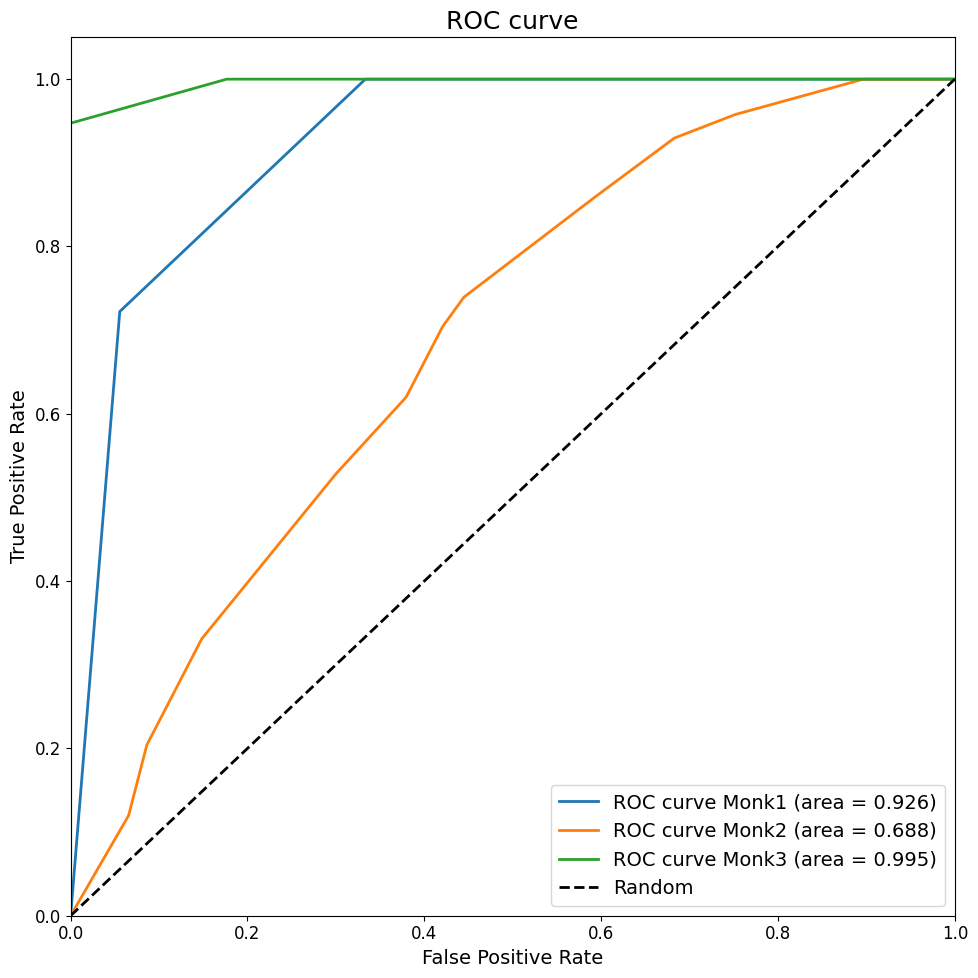

accuracy_score
0.8333333333333334
0.6157407407407407
0.9722222222222222
precision_score
0.8
0.44871794871794873
1.0


In [310]:
monk1CR = classification_report(monk1.labelTest, treeMonk1.predict(monk1.featuresTest))
monk2CR = classification_report(monk2.labelTest, treeMonk2.predict(monk2.featuresTest))
monk3CR = classification_report(monk3.labelTest, treeMonk3.predict(monk3.featuresTest))

print(f"Classification Report Monk1\n{monk1CR}")
print(f"Classification Report Monk2\n{monk2CR}")
print(f"Classification Report Monk3\n{monk3CR}")

fpr1, tpr1, thresholds1 = roc_curve(monk1.labelTest, treeMonk1.predict_proba(monk1.featuresTest)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(monk2.labelTest, treeMonk2.predict_proba(monk2.featuresTest)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(monk3.labelTest, treeMonk3.predict_proba(monk3.featuresTest)[:,1])
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

# rocFig, rocax = plt.subplots(1, 3, figsize=(15, 5))
# rocax[0].plot(fpr1, tpr1, lw=2, label=f'ROC curve (area = {roc_auc1:.3f})', color='orange')
# rocax[0].plot([0, 1], [0, 1], lw=2, linestyle='--', color='skyblue', label='Random')
# rocax[0].set_xlim([0.0, 1.0])
# rocax[0].set_ylim([0.0, 1.05])
# rocax[0].set_ylabel('True Positive Rate')
# # plt.xlabel('False Positive Rate')
# rocax[0].set_title('ROC curve Monk1')
# rocax[0].legend(loc="lower right")
# rocax[1].plot(fpr2, tpr2, lw=2, label=f'ROC curve (area = {roc_auc2:.3f})', color='orange')
# rocax[1].plot([0, 1], [0, 1], lw=2, linestyle='--', color='skyblue', label='Random')
# rocax[1].set_xlim([0.0, 1.0])
# rocax[1].set_ylim([0.0, 1.05])
# rocax[1].set_ylabel('True Positive Rate')
# rocax[1].set_xlabel('False Positive Rate')
# rocax[1].set_title('ROC curve Monk2')
# rocax[1].legend(loc="lower right")
# rocax[2].plot(fpr3, tpr3, lw=2, label=f'ROC curve (area = {roc_auc3:.3f})', color='orange')
# rocax[2].plot([0, 1], [0, 1], lw=2, linestyle='--', color='skyblue', label='Random')
# rocax[2].set_xlim([0.0, 1.0])
# rocax[2].set_ylim([0.0, 1.05])
# rocax[2].set_ylabel('True Positive Rate')
# rocax[2].legend(loc="lower right")
# rocax[2].set_title('ROC curve Monk3')
plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, lw=2, label=f'ROC curve Monk1 (area = {roc_auc1:.3f})')
plt.plot(fpr2, tpr2, lw=2, label=f'ROC curve Monk2 (area = {roc_auc2:.3f})')
plt.plot(fpr3, tpr3, lw=2, label=f'ROC curve Monk3 (area = {roc_auc3:.3f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='black', label='Random')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.axes
plt.tight_layout()
plt.show()

print("accuracy_score")
print(accuracy_score(monk1.labelTest, treeMonk1.predict(monk1.featuresTest)))
print(accuracy_score(monk2.labelTest, treeMonk2.predict(monk2.featuresTest)))
print(accuracy_score(monk3.labelTest, treeMonk3.predict(monk3.featuresTest)))

print("precision_score")
print(precision_score(monk1.labelTest, treeMonk1.predict(monk1.featuresTest)))
print(precision_score(monk2.labelTest, treeMonk2.predict(monk2.featuresTest)))
print(precision_score(monk3.labelTest, treeMonk3.predict(monk3.featuresTest)))

***Random forest***

In [311]:
forestMonk = RandomForestClassifier(random_state=42)

parameters = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [5, 10, 50],
    'max_depth': [2, 4, 5, None],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None],
}

forestMonk1 = GridSearchCV(forestMonk, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk2 = GridSearchCV(forestMonk, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk3 = GridSearchCV(forestMonk, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')

forestMonk1.fit(monk1.featuresTrain, monk1.labelTrain)
forestMonk2.fit(monk2.featuresTrain, monk2.labelTrain)
forestMonk3.fit(monk3.featuresTrain, monk3.labelTrain)

print(f"Monk1 best parameters: {forestMonk1.best_params_}")
print(f"Monk2 best parameters: {forestMonk2.best_params_}")
print(f"Monk3 best parameters: {forestMonk3.best_params_}")

c:\Program Files\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Program Files\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Monk1 best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'n_estimators': 50}
Monk2 best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 10}
Monk3 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'n_estimators': 50}


c:\Program Files\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


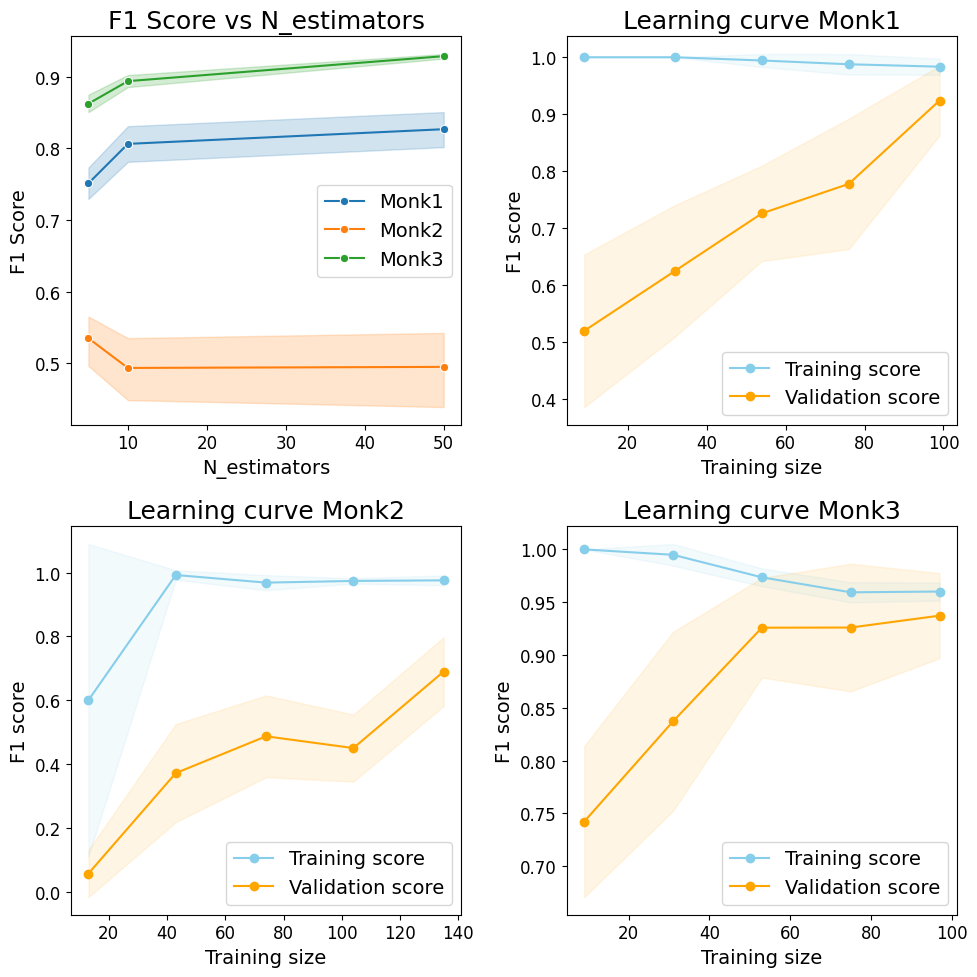

In [312]:
# sns.lineplot(data=pd.DataFrame(forestMonk1.cv_results_), x='param_n_estimators', y='mean_test_f1', label='Monk1', marker='o')
# sns.lineplot(data=pd.DataFrame(forestMonk2.cv_results_), x='param_n_estimators', y='mean_test_f1', label='Monk2', marker='o')
# sns.lineplot(data=pd.DataFrame(forestMonk3.cv_results_), x='param_n_estimators', y='mean_test_f1', label='Monk3', marker='o')
# plt.tight_layout()
# plt.show()

fig3, ax3 = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(data=pd.DataFrame(forestMonk1.cv_results_), x='param_n_estimators', y='mean_test_f1', label='Monk1', marker='o', ax=ax3[0,0])
sns.lineplot(data=pd.DataFrame(forestMonk2.cv_results_), x='param_n_estimators', y='mean_test_f1', label='Monk2', marker='o', ax=ax3[0,0])
sns.lineplot(data=pd.DataFrame(forestMonk3.cv_results_), x='param_n_estimators', y='mean_test_f1', label='Monk3', marker='o', ax=ax3[0,0])
ax3[0,0].set_title('F1 Score vs N_estimators')
ax3[0,0].set_xlabel('N_estimators')
ax3[0,0].set_ylabel('F1 Score')
ax3[0,0].legend()

train_sizes, train_scores, val_scores = learning_curve(forestMonk1.best_estimator_,
                                            monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[0,1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[0,1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[0,1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[0,1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[0,1].set_title('Learning curve Monk1')
ax3[0,1].set_xlabel('Training size')
ax3[0,1].set_ylabel('F1 score')
ax3[0,1].legend()
train_sizes, train_scores, val_scores = learning_curve(forestMonk2.best_estimator_,
                                            monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[1,0].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[1,0].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[1,0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[1,0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[1,0].set_title('Learning curve Monk2')
ax3[1,0].set_xlabel('Training size')
ax3[1,0].set_ylabel('F1 score')
ax3[1,0].legend()
train_sizes, train_scores, val_scores = learning_curve(forestMonk3.best_estimator_,
                                            monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[1,1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[1,1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[1,1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[1,1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[1,1].set_title('Learning curve Monk3')
ax3[1,1].set_xlabel('Training size')
ax3[1,1].set_ylabel('F1 score')
ax3[1,1].legend()
plt.tight_layout()
plt.show()

Monk 1 e 2 sembrano overfittare, togliamo max_depth = None

Monk1 best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'n_estimators': 50}
Monk2 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'n_estimators': 10}


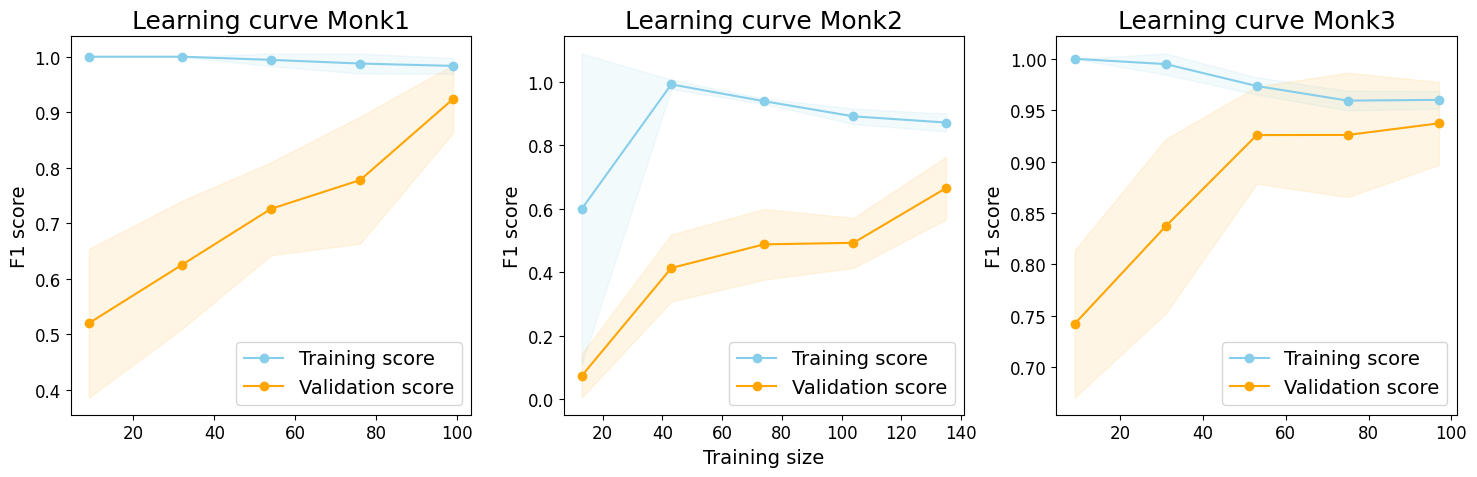

In [313]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [5, 10, 50],
    'max_depth': [2, 4, 5],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

forestMonk1 = GridSearchCV(forestMonk, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk2 = GridSearchCV(forestMonk, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk1.fit(monk1.featuresTrain, monk1.labelTrain)
forestMonk2.fit(monk2.featuresTrain, monk2.labelTrain)

print(f"Monk1 best parameters: {forestMonk1.best_params_}")
print(f"Monk2 best parameters: {forestMonk2.best_params_}")

fig3, ax3 = plt.subplots(1, 3, figsize=(15, 5))
train_sizes, train_scores, val_scores = learning_curve(forestMonk1.best_estimator_,
                                            monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[0].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[0].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[0].set_title('Learning curve Monk1')
# ax3[0].set_xlabel('Training size')
ax3[0].set_ylabel('F1 score')
ax3[0].legend()
train_sizes, train_scores, val_scores = learning_curve(forestMonk2.best_estimator_,
                                            monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[1].set_title('Learning curve Monk2')
ax3[1].set_xlabel('Training size')
ax3[1].set_ylabel('F1 score')
ax3[1].legend()
train_sizes, train_scores, val_scores = learning_curve(forestMonk3.best_estimator_,
                                            monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[2].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[2].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[2].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[2].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[2].set_title('Learning curve Monk3')
# ax3[2].set_xlabel('Training size')
ax3[2].set_ylabel('F1 score')
ax3[2].legend()
plt.tight_layout()
plt.show()

Abbiamo leggermente migliorato il risultato quindi continuiamo riducendo il numero di alberi

c:\Program Files\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Monk1 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'n_estimators': 10}
Monk2 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'n_estimators': 10}
Monk3 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 12}


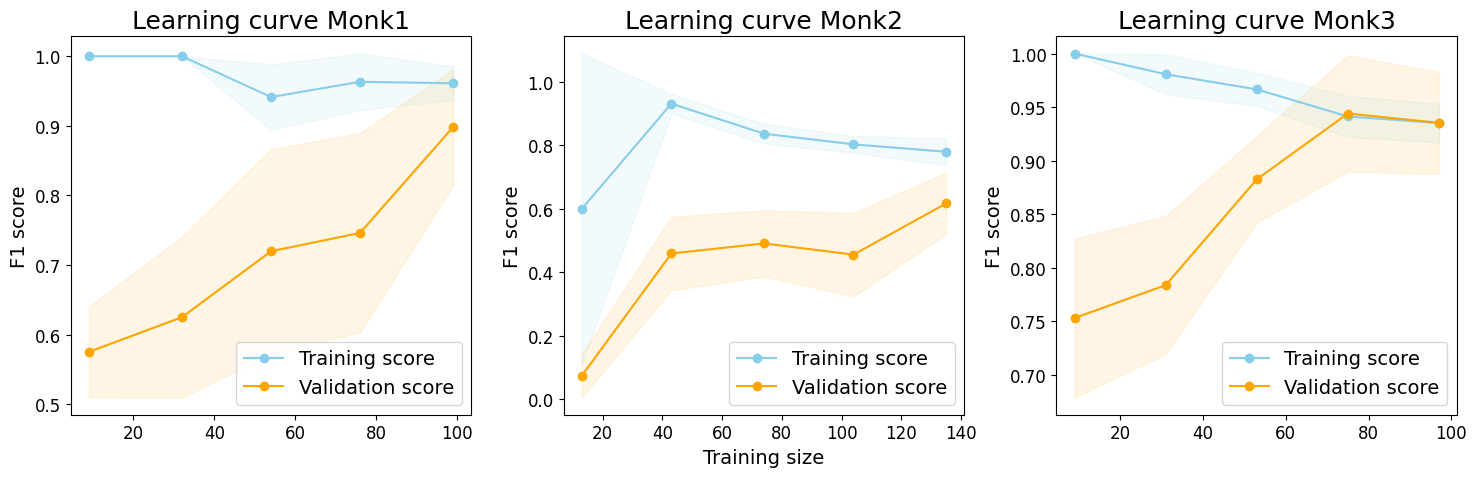

In [314]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [5, 7, 10, 12],
    'max_depth': [2, 3, 4],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

forestMonk1 = GridSearchCV(forestMonk, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk2 = GridSearchCV(forestMonk, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk3 = GridSearchCV(forestMonk, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk1.fit(monk1.featuresTrain, monk1.labelTrain)
forestMonk2.fit(monk2.featuresTrain, monk2.labelTrain)
forestMonk3.fit(monk3.featuresTrain, monk3.labelTrain)

print(f"Monk1 best parameters: {forestMonk1.best_params_}")
print(f"Monk2 best parameters: {forestMonk2.best_params_}")
print(f"Monk3 best parameters: {forestMonk3.best_params_}")

fig3, ax3 = plt.subplots(1, 3, figsize=(15, 5))
train_sizes, train_scores, val_scores = learning_curve(forestMonk1.best_estimator_,
                                            monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[0].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[0].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[0].set_title('Learning curve Monk1')
# ax3[0].set_xlabel('Training size')
ax3[0].set_ylabel('F1 score')
ax3[0].legend()
train_sizes, train_scores, val_scores = learning_curve(forestMonk2.best_estimator_,
                                            monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[1].set_title('Learning curve Monk2')
ax3[1].set_xlabel('Training size')
ax3[1].set_ylabel('F1 score')
ax3[1].legend(loc='lower right')
train_sizes, train_scores, val_scores = learning_curve(forestMonk3.best_estimator_,
                                            monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[2].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[2].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[2].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[2].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[2].set_title('Learning curve Monk3')
# ax3[2].set_xlabel('Training size')
ax3[2].set_ylabel('F1 score')
ax3[2].legend()
plt.tight_layout()
plt.show()

Monk1 e monk3 non sembrano aver subito la riduzione del numero di estimatori (decision trees della random forest).

Vediamo come varia l'F1 con il numero di alberi

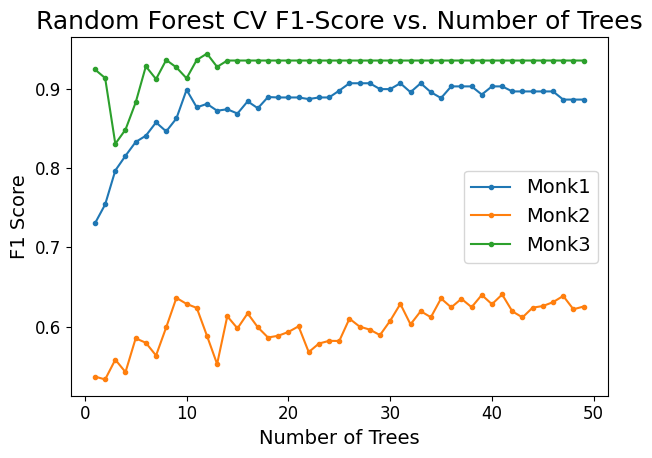

0.9066853146853147 26
0.6406827366182204 41
0.944 12


In [315]:
m1F1 = []
m2F1 = []
m3F1 = []
confMat1 = []
confMat2 = []
maxN = 50
param1 = forestMonk1.best_params_
param2 = forestMonk2.best_params_
param3 = forestMonk3.best_params_
del param1['n_estimators']
del param2['n_estimators']
del param3['n_estimators']

for n in range(1, maxN):
    rf_temp1 = RandomForestClassifier(n_estimators=n, **param1, random_state=42)
    rf_temp2 = RandomForestClassifier(n_estimators=n, **param2, random_state=42)
    rf_temp3 = RandomForestClassifier(n_estimators=n, **param3, random_state=42)
    rf_temp1.fit(monk1.featuresTrain, monk1.labelTrain)
    rf_temp2.fit(monk2.featuresTrain, monk2.labelTrain)
    rf_temp3.fit(monk3.featuresTrain, monk3.labelTrain)
    m1F1.append(np.mean(cross_val_score(rf_temp1, monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1')))
    m2F1.append(np.mean(cross_val_score(rf_temp2, monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1')))
    m3F1.append(np.mean(cross_val_score(rf_temp3, monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1')))
    

plt.plot(range(1, maxN), m1F1, label="Monk1", marker='.')
plt.plot(range(1, maxN), m2F1, label="Monk2", marker='.')
plt.plot(range(1, maxN), m3F1, label="Monk3", marker='.')
plt.legend()
plt.xlabel("Number of Trees")
plt.ylabel("F1 Score")
plt.title("Random Forest CV F1-Score vs. Number of Trees")
plt.tight_layout()
plt.show()

print(max(m1F1), np.argmax(m1F1)+1) # Parte da 1 quindi l'n-esimo elemento = n+1
print(max(m2F1), np.argmax(m2F1)+1)
print(max(m3F1), np.argmax(m3F1)+1)


Verifichiamo con i valori trovati

c:\Program Files\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Program Files\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Monk1 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'n_estimators': np.int64(26)}
Monk2 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'n_estimators': np.int64(41)}
Monk3 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': np.int64(12)}


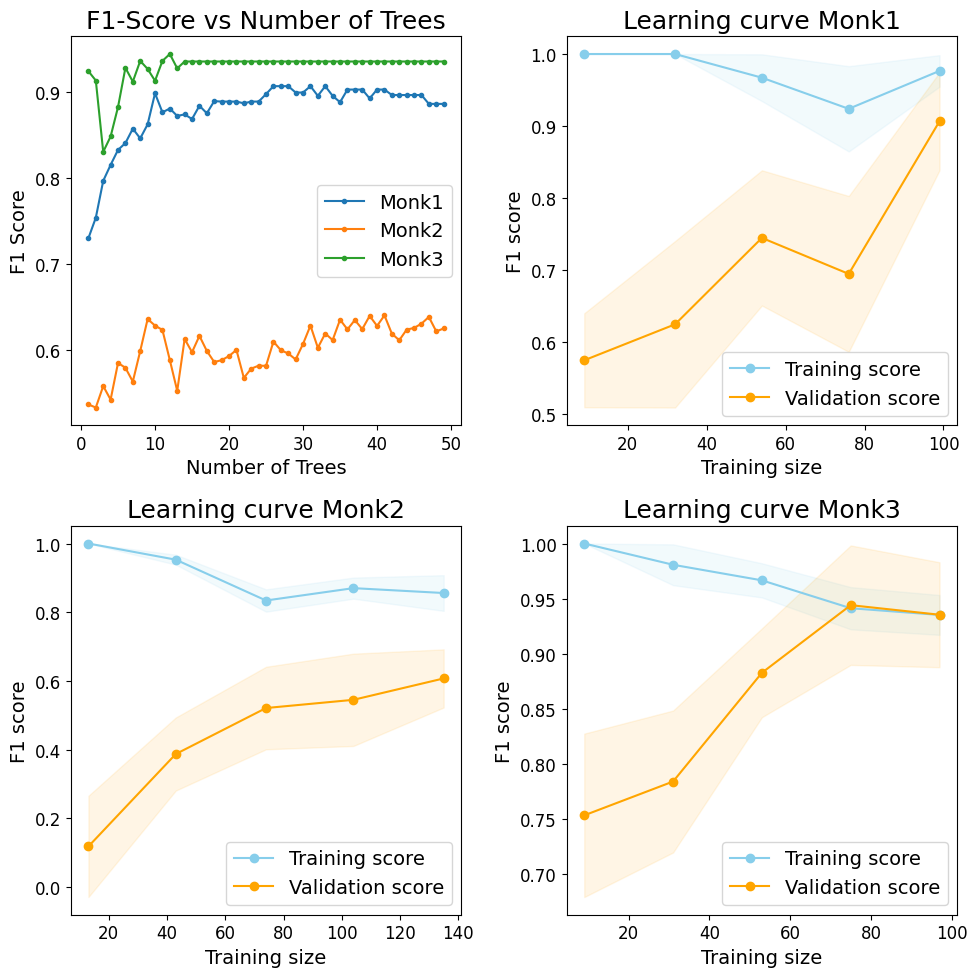

In [316]:
parameters1 = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [np.argmax(m1F1)+1],
    'max_depth': [2, 3, 4],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

parameters2 = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [np.argmax(m2F1)+1],
    'max_depth': [2, 3, 4],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

parameters3 = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [np.argmax(m3F1)+1],
    'max_depth': [2, 3, 4],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

forestMonk1 = GridSearchCV(forestMonk, parameters1, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk2 = GridSearchCV(forestMonk, parameters2, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk3 = GridSearchCV(forestMonk, parameters3, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
forestMonk1.fit(monk1.featuresTrain, monk1.labelTrain)
forestMonk2.fit(monk2.featuresTrain, monk2.labelTrain)
forestMonk3.fit(monk3.featuresTrain, monk3.labelTrain)

print(f"Monk1 best parameters: {forestMonk1.best_params_}")
print(f"Monk2 best parameters: {forestMonk2.best_params_}")
print(f"Monk3 best parameters: {forestMonk3.best_params_}")

fig3, ax3 = plt.subplots(2, 2, figsize=(10, 10))
ax3[0,0].plot(range(1, maxN), m1F1, label="Monk1", marker='.')
ax3[0,0].plot(range(1, maxN), m2F1, label="Monk2", marker='.')
ax3[0,0].plot(range(1, maxN), m3F1, label="Monk3", marker='.')
ax3[0,0].legend()
ax3[0,0].set_xlabel("Number of Trees")
ax3[0,0].set_ylabel("F1 Score")
ax3[0,0].set_title("F1-Score vs Number of Trees")
train_sizes, train_scores, val_scores = learning_curve(forestMonk1.best_estimator_,
                                            monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[0,1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[0,1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[0,1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[0,1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[0,1].set_title('Learning curve Monk1')
ax3[0,1].set_xlabel('Training size')
ax3[0,1].set_ylabel('F1 score')
ax3[0,1].legend()
train_sizes, train_scores, val_scores = learning_curve(forestMonk2.best_estimator_,
                                            monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[1,0].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[1,0].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[1,0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[1,0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[1,0].set_title('Learning curve Monk2')
ax3[1,0].set_xlabel('Training size')
ax3[1,0].set_ylabel('F1 score')
ax3[1,0].legend()
train_sizes, train_scores, val_scores = learning_curve(forestMonk3.best_estimator_,
                                            monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[1,1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[1,1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[1,1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[1,1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[1,1].set_title('Learning curve Monk3')
ax3[1,1].set_xlabel('Training size')
ax3[1,1].set_ylabel('F1 score')
ax3[1,1].legend()
plt.tight_layout()
plt.show()

Procediamo con gli score, confusion matrix, roc-auc curve e classification report


Random Forest
Monk-1 score: 0.9647058823529412
Monk-2 score: 0.6273291925465838
Monk-3 score: 0.972972972972973


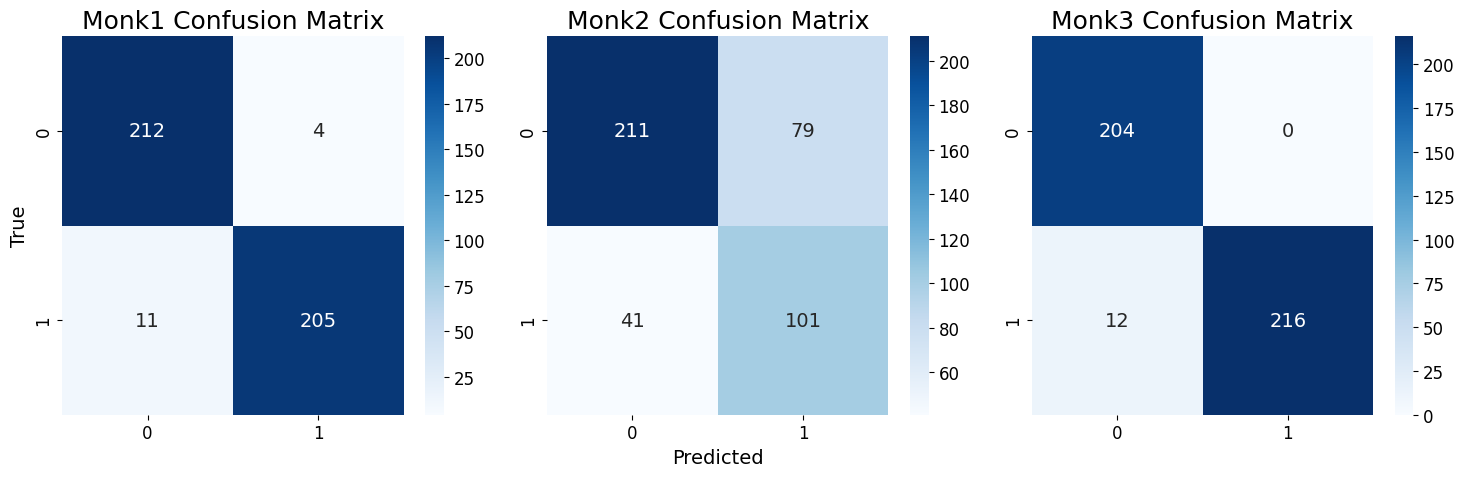

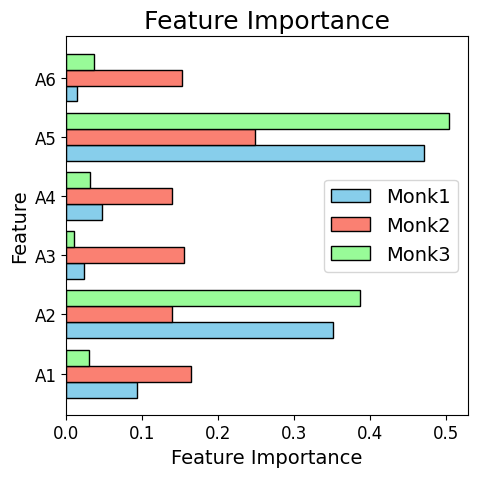

Classification Report Monk1
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       216
           1       0.98      0.95      0.96       216

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432

Classification Report Monk2
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       290
           1       0.56      0.71      0.63       142

    accuracy                           0.72       432
   macro avg       0.70      0.72      0.70       432
weighted avg       0.75      0.72      0.73       432

Classification Report Monk3
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97 

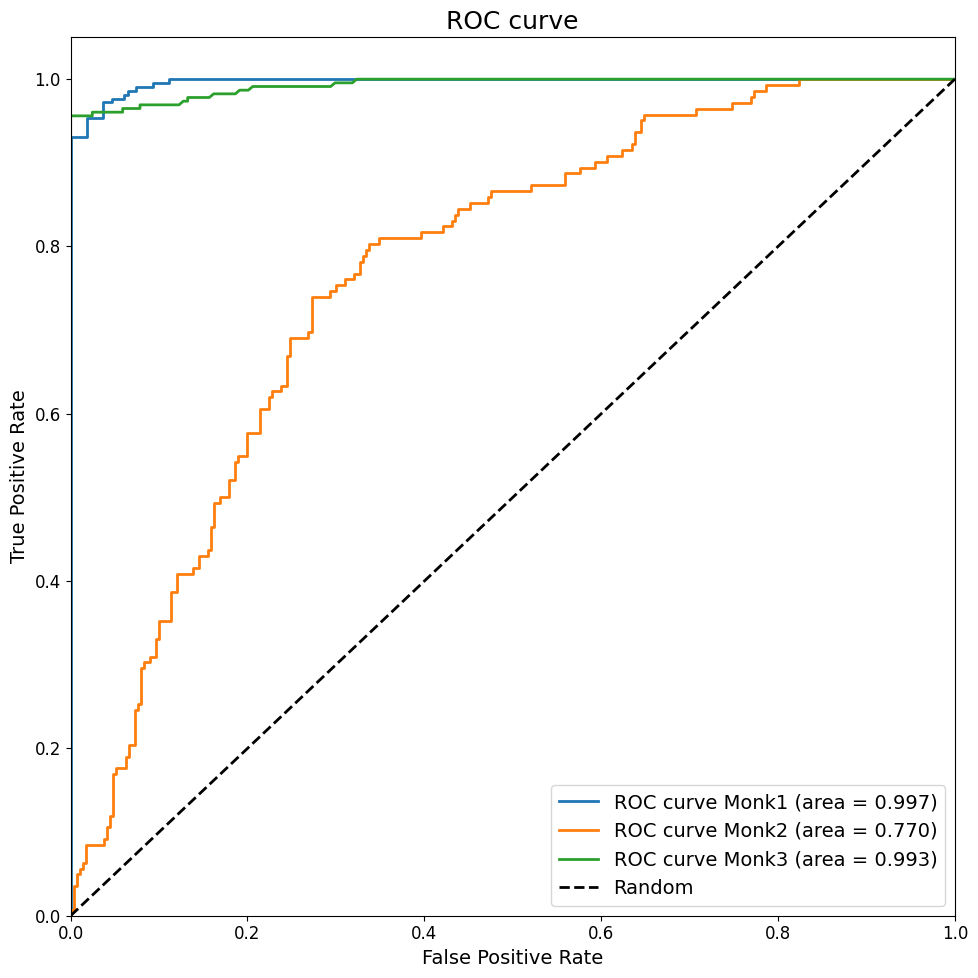

accuracy_score
0.9652777777777778
0.7222222222222222
0.9722222222222222
precision_score
0.9808612440191388
0.5611111111111111
1.0


In [318]:
forestMonk1Score = forestMonk1.score(monk1.featuresTest, monk1.labelTest)
forestMonk2Score = forestMonk2.score(monk2.featuresTest, monk2.labelTest)
forestMonk3Score = forestMonk3.score(monk3.featuresTest, monk3.labelTest)

print("\nRandom Forest")
print(f"Monk-1 score: {forestMonk1Score}")
print(f"Monk-2 score: {forestMonk2Score}")
print(f"Monk-3 score: {forestMonk3Score}")

fig1, ax1 = plt.subplots(1, 3, figsize=(15, 5))
confMatrixMonk1 = confusion_matrix(monk1.labelTest, forestMonk1.predict(monk1.featuresTest))
confMatrixMonk2 = confusion_matrix(monk2.labelTest, forestMonk2.predict(monk2.featuresTest))
confMatrixMonk3 = confusion_matrix(monk3.labelTest, forestMonk3.predict(monk3.featuresTest))
# print(confMatrixMonk1[0][1])
sns.heatmap(confMatrixMonk1, annot=True, fmt="d", cmap="Blues", ax=ax1[0])
sns.heatmap(confMatrixMonk2, annot=True, fmt="d", cmap="Blues", ax=ax1[1])
sns.heatmap(confMatrixMonk3, annot=True, fmt="d", cmap="Blues", ax=ax1[2])
ax1[0].set_title('Monk1 Confusion Matrix')
ax1[1].set_title('Monk2 Confusion Matrix')
ax1[2].set_title('Monk3 Confusion Matrix')
ax1[0].set(ylabel="True")
ax1[1].set(xlabel="Predicted")
plt.tight_layout()
plt.show()

monk1Feat = forestMonk1.best_estimator_.feature_importances_
monk2Feat = forestMonk2.best_estimator_.feature_importances_
monk3Feat = forestMonk3.best_estimator_.feature_importances_

x = np.arange(6)
width = 0.27

plt.figure(figsize=(5, 5))
plt.barh(x - width, monk1Feat, height=width, label='Monk1', color='skyblue', edgecolor='black')
plt.barh(x, monk2Feat, height=width, label="Monk2", color='salmon', edgecolor='black')
plt.barh(x + width, monk3Feat, height=width, label="Monk3", color='palegreen', edgecolor='black')
plt.yticks(x, ['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.legend()
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

monk1CR = classification_report(monk1.labelTest, forestMonk1.predict(monk1.featuresTest))
monk2CR = classification_report(monk2.labelTest, forestMonk2.predict(monk2.featuresTest))
monk3CR = classification_report(monk3.labelTest, forestMonk3.predict(monk3.featuresTest))

print(f"Classification Report Monk1\n{monk1CR}")
print(f"Classification Report Monk2\n{monk2CR}")
print(f"Classification Report Monk3\n{monk3CR}")

fpr1, tpr1, thresholds1 = roc_curve(monk1.labelTest, forestMonk1.predict_proba(monk1.featuresTest)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(monk2.labelTest, forestMonk2.predict_proba(monk2.featuresTest)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(monk3.labelTest, forestMonk3.predict_proba(monk3.featuresTest)[:,1])
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

# rocFig, rocax = plt.subplots(1, 3, figsize=(15, 5))
# rocax[0].plot(fpr1, tpr1, lw=2, label=f'ROC curve (area = {roc_auc1:.3f})', color='orange')
# rocax[0].plot([0, 1], [0, 1], lw=2, linestyle='--', color='skyblue', label='Random')
# rocax[0].set_xlim([0.0, 1.0])
# rocax[0].set_ylim([0.0, 1.05])
# rocax[0].set_ylabel('True Positive Rate')
# # plt.xlabel('False Positive Rate')
# rocax[0].set_title('ROC curve Monk1')
# rocax[0].legend(loc="lower right")
# rocax[1].plot(fpr2, tpr2, lw=2, label=f'ROC curve (area = {roc_auc2:.3f})', color='orange')
# rocax[1].plot([0, 1], [0, 1], lw=2, linestyle='--', color='skyblue', label='Random')
# rocax[1].set_xlim([0.0, 1.0])
# rocax[1].set_ylim([0.0, 1.05])
# rocax[1].set_ylabel('True Positive Rate')
# rocax[1].set_xlabel('False Positive Rate')
# rocax[1].set_title('ROC curve Monk2')
# rocax[1].legend(loc="lower right")
# rocax[2].plot(fpr3, tpr3, lw=2, label=f'ROC curve (area = {roc_auc3:.3f})', color='orange')
# rocax[2].plot([0, 1], [0, 1], lw=2, linestyle='--', color='skyblue', label='Random')
# rocax[2].set_xlim([0.0, 1.0])
# rocax[2].set_ylim([0.0, 1.05])
# rocax[2].set_ylabel('True Positive Rate')
# rocax[2].legend(loc="lower right")
# rocax[2].set_title('ROC curve Monk3')
plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, lw=2, label=f'ROC curve Monk1 (area = {roc_auc1:.3f})')
plt.plot(fpr2, tpr2, lw=2, label=f'ROC curve Monk2 (area = {roc_auc2:.3f})')
plt.plot(fpr3, tpr3, lw=2, label=f'ROC curve Monk3 (area = {roc_auc3:.3f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='black', label='Random')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.tight_layout()
plt.show()

print("accuracy_score")
print(accuracy_score(monk1.labelTest, forestMonk1.predict(monk1.featuresTest)))
print(accuracy_score(monk2.labelTest, forestMonk2.predict(monk2.featuresTest)))
print(accuracy_score(monk3.labelTest, forestMonk3.predict(monk3.featuresTest)))

print("precision_score")
print(precision_score(monk1.labelTest, forestMonk1.predict(monk1.featuresTest)))
print(precision_score(monk2.labelTest, forestMonk2.predict(monk2.featuresTest)))
print(precision_score(monk3.labelTest, forestMonk3.predict(monk3.featuresTest)))

**Logistic Reggression**

Ci aspettiamo che tra i solver più performanti ci sia 'liblinear' che dalla documentazione risulta ideale per piccoli dataset mentre 'saga'/'sag' sarebbero ideale per i dataset di grandi dimensioni. ('liblinear' è ottimo anche per i problemi multiclasse)


‘newton-cholesky’ pare essere una buona scelta quando c'è un grande numero di sample (n_samples >> n_features * n_classes)

In [293]:
logReg = LogisticRegression(random_state=42)

parameters = {
    'solver' : ["lbfgs", 'liblinear', "newton-cg", "sag", "saga"],  
    'class_weight' : [None, "balanced"],         
    'max_iter' : [100, 200, 500, 1000, 5000],
    'C' : [0.1, 0.5, 1, 2, 5, 10],           # Inverso della regolarizzazione (1 di default)
    'tol' : [1e-4, 1e-5, 1e-6, 1e-7]          # Tollerance for stopping criteria
    
    }

logRegMonk1 = GridSearchCV(logReg, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
logRegMonk2 = GridSearchCV(logReg, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
logRegMonk3 = GridSearchCV(logReg, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')

logRegMonk1.fit(monk1.featuresTrain, monk1.labelTrain)
logRegMonk2.fit(monk2.featuresTrain, monk2.labelTrain)
logRegMonk3.fit(monk3.featuresTrain, monk3.labelTrain)

print(f"Monk1 best parameters: {logRegMonk1.best_params_}")
print(f"Monk2 best parameters: {logRegMonk2.best_params_}")
print(f"Monk3 best parameters: {logRegMonk3.best_params_}")

C:\Users\giuse\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Monk1 best parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'solver': 'liblinear', 'tol': 0.0001}
Monk2 best parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'saga', 'tol': 0.0001}
Monk3 best parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 100, 'solver': 'lbfgs', 'tol': 0.0001}


C:\Users\giuse\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\giuse\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\giuse\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\giuse\AppData\Roaming\Python\Python313\site-pac

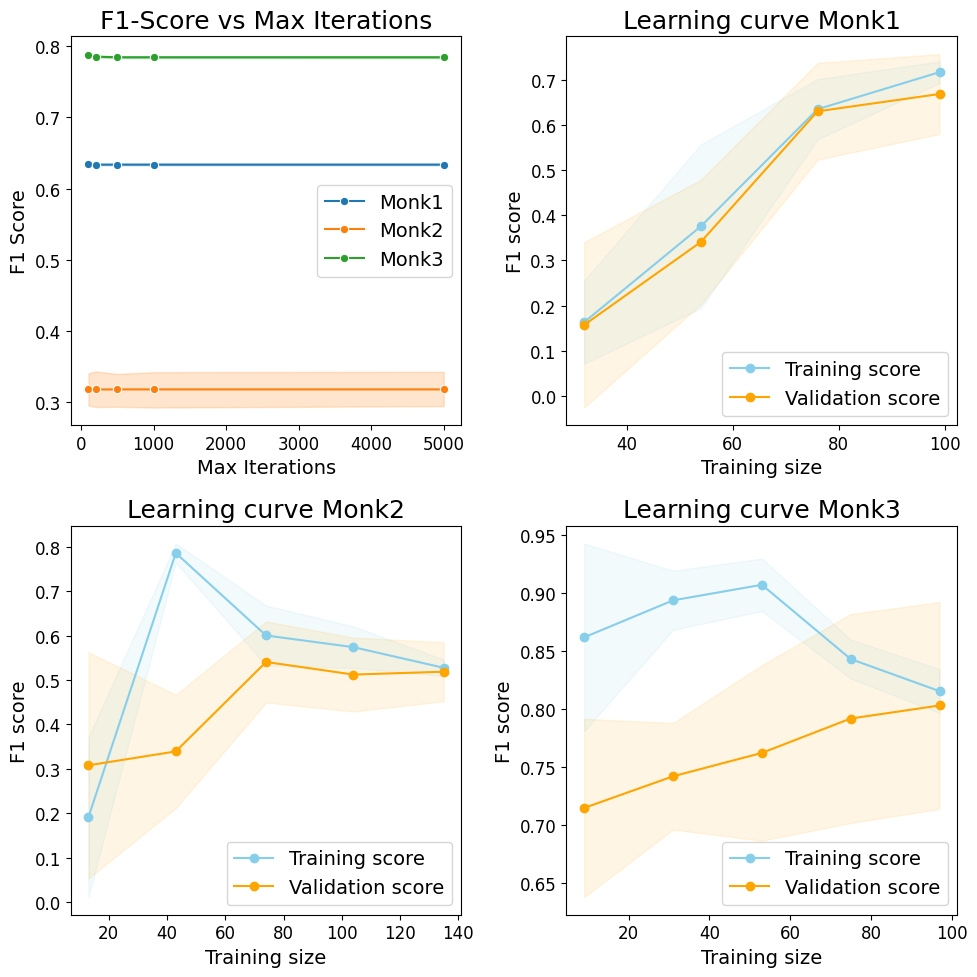

In [ ]:
fig4, ax4 = plt.subplots(2, 2, figsize=(10, 10))
sns.lineplot(data=pd.DataFrame(logRegMonk1.cv_results_), x='param_max_iter', y='mean_test_f1', label='Monk1', marker='o', ax=ax4[0][0])
sns.lineplot(data=pd.DataFrame(logRegMonk2.cv_results_), x='param_max_iter', y='mean_test_f1', label='Monk2', marker='o', ax=ax4[0][0])
sns.lineplot(data=pd.DataFrame(logRegMonk3.cv_results_), x='param_max_iter', y='mean_test_f1', label='Monk3', marker='o', ax=ax4[0][0])
ax4[0][0].set_title('F1-Score vs Max Iterations')
ax4[0][0].set_xlabel('Max Iterations')
ax4[0][0].set_ylabel('F1 Score')
ax4[0][0].legend()

train_sizes, train_scores, val_scores = learning_curve(logRegMonk1.best_estimator_,
                                            monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax4[0][1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax4[0][1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax4[0][1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax4[0][1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax4[0][1].set_title('Learning curve Monk1')
ax4[0][1].set_xlabel('Training size')
ax4[0][1].set_ylabel('F1 score')
ax4[0][1].legend()
train_sizes, train_scores, val_scores = learning_curve(logRegMonk2.best_estimator_,
                                            monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax4[1][0].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax4[1][0].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax4[1][0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax4[1][0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax4[1][0].set_title('Learning curve Monk2')
ax4[1][0].set_xlabel('Training size')
ax4[1][0].set_ylabel('F1 score')
ax4[1][0].legend()
train_sizes, train_scores, val_scores = learning_curve(logRegMonk3.best_estimator_,
                                            monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax4[1][1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax4[1][1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax4[1][1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax4[1][1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax4[1][1].set_title('Learning curve Monk3')
ax4[1][1].set_xlabel('Training size')
ax4[1][1].set_ylabel('F1 score')
ax4[1][1].legend()
plt.tight_layout()
plt.show()



Monk 1 e Monk 3 non sembrano overfittare, il monk2 sembra farlo sul secondo fit ma poi gli score ritornano comparabili.


Logistic Regression
Monk-1 score: 0.663594470046083
Monk-2 score: 0.4322766570605187
Monk-3 score: 0.8108108108108109


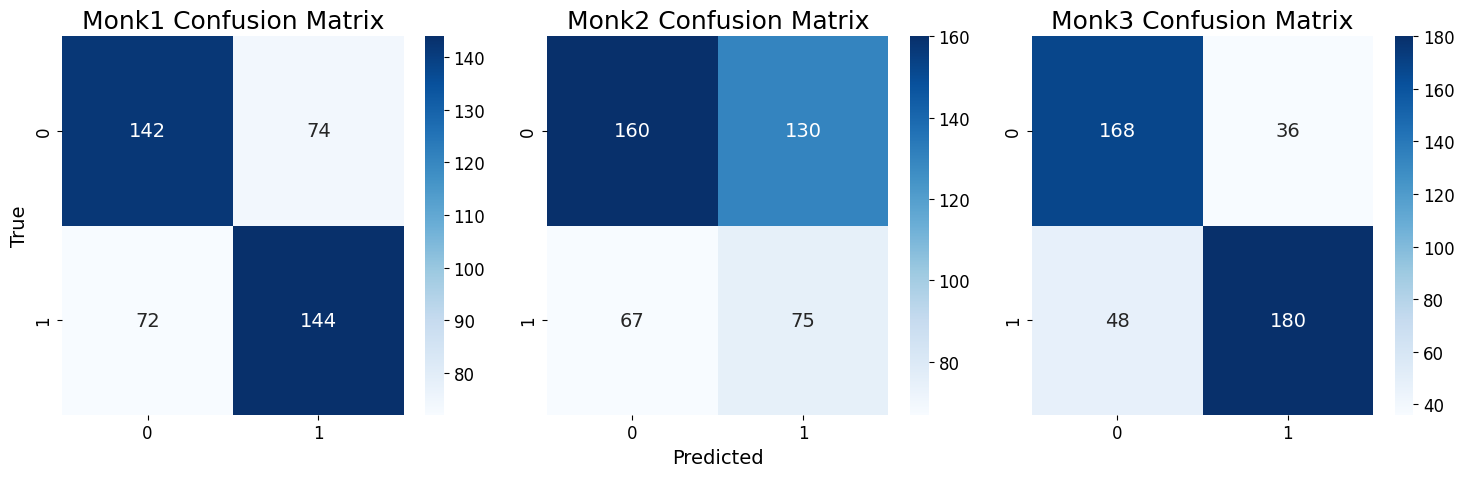

Classification Report Monk1
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       216
           1       0.98      0.95      0.96       216

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432

Classification Report Monk2
              precision    recall  f1-score   support

           0       0.84      0.73      0.78       290
           1       0.56      0.71      0.63       142

    accuracy                           0.72       432
   macro avg       0.70      0.72      0.70       432
weighted avg       0.75      0.72      0.73       432

Classification Report Monk3
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97 

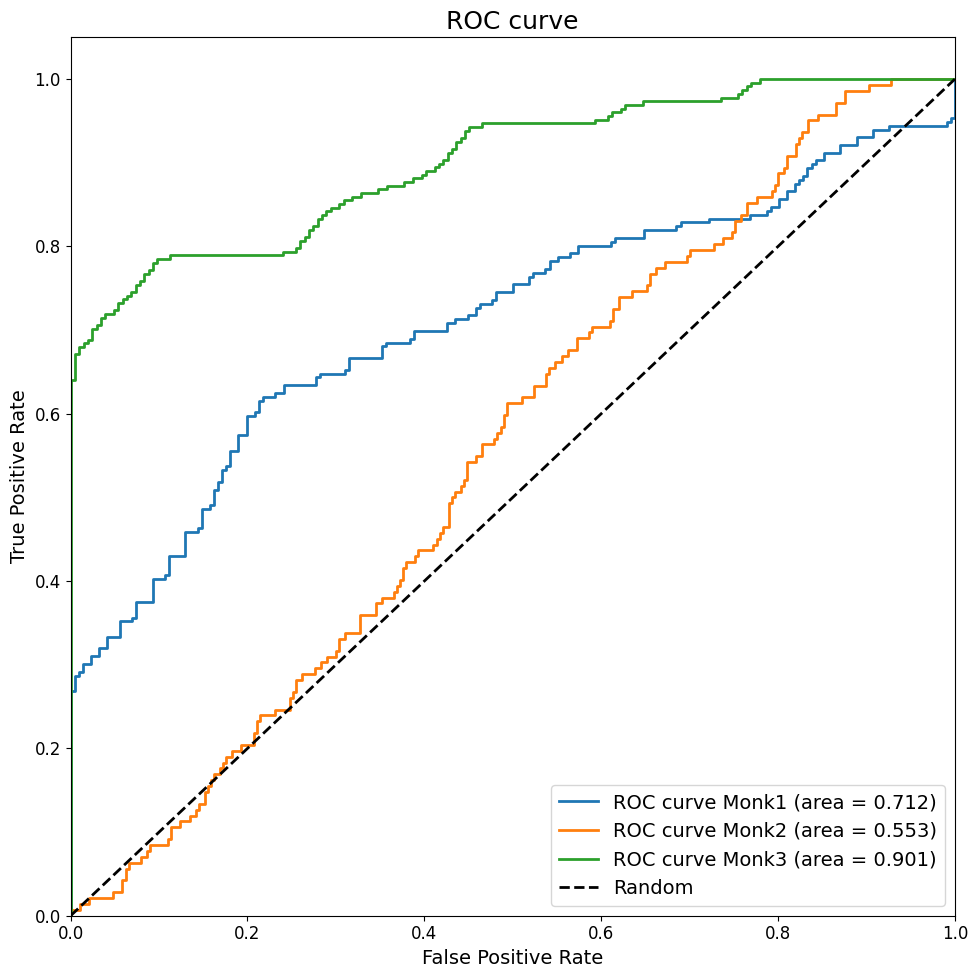

In [ ]:
logRegMonk1Score = logRegMonk1.score(monk1.featuresTest, monk1.labelTest)
logRegMonk2Score = logRegMonk2.score(monk2.featuresTest, monk2.labelTest)
logRegMonk3Score = logRegMonk3.score(monk3.featuresTest, monk3.labelTest)

print("\nLogistic Regression")
print(f"Monk-1 score: {logRegMonk1Score}")
print(f"Monk-2 score: {logRegMonk2Score}")
print(f"Monk-3 score: {logRegMonk3Score}")

fig5, ax5 = plt.subplots(1, 3, figsize=(15, 5))
confMatrixMonk1 = confusion_matrix(monk1.labelTest, logRegMonk1.predict(monk1.featuresTest))
confMatrixMonk2 = confusion_matrix(monk2.labelTest, logRegMonk2.predict(monk2.featuresTest))
confMatrixMonk3 = confusion_matrix(monk3.labelTest, logRegMonk3.predict(monk3.featuresTest))
sns.heatmap(confMatrixMonk1, annot=True, fmt="d", cmap="Blues", ax=ax5[0])
sns.heatmap(confMatrixMonk2, annot=True, fmt="d", cmap="Blues", ax=ax5[1])
sns.heatmap(confMatrixMonk3, annot=True, fmt="d", cmap="Blues", ax=ax5[2])
ax5[0].set_title('Monk1 Confusion Matrix')
ax5[1].set_title('Monk2 Confusion Matrix')
ax5[2].set_title('Monk3 Confusion Matrix')
ax5[0].set(ylabel="True")
ax5[1].set(xlabel="Predicted")
plt.tight_layout()
plt.show()

monk1CR = classification_report(monk1.labelTest, forestMonk1.predict(monk1.featuresTest))
monk2CR = classification_report(monk2.labelTest, forestMonk2.predict(monk2.featuresTest))
monk3CR = classification_report(monk3.labelTest, forestMonk3.predict(monk3.featuresTest))

print(f"Classification Report Monk1\n{monk1CR}")
print(f"Classification Report Monk2\n{monk2CR}")
print(f"Classification Report Monk3\n{monk3CR}")

fpr1, tpr1, thresholds1 = roc_curve(monk1.labelTest, logRegMonk1.predict_proba(monk1.featuresTest)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(monk2.labelTest, logRegMonk2.predict_proba(monk2.featuresTest)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(monk3.labelTest, logRegMonk3.predict_proba(monk3.featuresTest)[:,1])
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, lw=2, label=f'ROC curve Monk1 (area = {roc_auc1:.3f})')
plt.plot(fpr2, tpr2, lw=2, label=f'ROC curve Monk2 (area = {roc_auc2:.3f})')
plt.plot(fpr3, tpr3, lw=2, label=f'ROC curve Monk3 (area = {roc_auc3:.3f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', label='Random', color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
# plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

In [ ]:
print("Precision Score")
print(f"Monk1: {precision_score(monk1.labelTest, logRegMonk1.predict(monk1.featuresTest)):0.3f}")
print(f"Monk2: {precision_score(monk2.labelTest, logRegMonk2.predict(monk2.featuresTest)):0.3f}")
print(f"Monk3: {precision_score(monk3.labelTest, logRegMonk3.predict(monk3.featuresTest)):0.3f}")

print("Accuracy Score")
print(f"Monk1: {accuracy_score(monk1.labelTest, logRegMonk1.predict(monk1.featuresTest)):0.3f}")
print(f"Monk2: {accuracy_score(monk2.labelTest, logRegMonk2.predict(monk2.featuresTest)):0.3f}")
print(f"Monk3: {accuracy_score(monk3.labelTest, logRegMonk3.predict(monk3.featuresTest)):0.3f}")

print("log loss")
print(f"Monk1: {log_loss(monk1.labelTest, logRegMonk1.predict_proba(monk1.featuresTest)):0.3f}")
print(f"Monk2: {log_loss(monk2.labelTest, logRegMonk2.predict_proba(monk2.featuresTest)):0.3f}")
print(f"Monk3: {log_loss(monk3.labelTest, logRegMonk3.predict_proba(monk3.featuresTest)):0.3f}")


Precision Score
Monk1: 0.661
Monk2: 0.366
Monk3: 0.833
Accuracy Score
Monk1: 0.662
Monk2: 0.544
Monk3: 0.806
log loss
Monk1: 0.627
Monk2: 0.691
Monk3: 0.460


**Extra Trees**

Simile alla random forest ma splitta i nodi in maniera randomica rendendo il modello più resistente all'overfitting e più veloce (partiamo quindi da parametri simili a quelli utilizzati dopo l'analisi della random forest)

In [297]:
extra = ExtraTreesClassifier(random_state=42)

parameters = {
    'n_estimators': [5, 10, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4,],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

extraMonk1 = GridSearchCV(extra, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
extraMonk2 = GridSearchCV(extra, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
extraMonk3 = GridSearchCV(extra, parameters, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')

extraMonk1.fit(monk1.featuresTrain, monk1.labelTrain)
extraMonk2.fit(monk2.featuresTrain, monk2.labelTrain)
extraMonk3.fit(monk3.featuresTrain, monk3.labelTrain)

print(f"Monk1 best parameters: {extraMonk1.best_params_}")
print(f"Monk2 best parameters: {extraMonk2.best_params_}")
print(f"Monk3 best parameters: {extraMonk3.best_params_}")

Monk1 best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'n_estimators': 5}
Monk2 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}
Monk3 best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'n_estimators': 10}


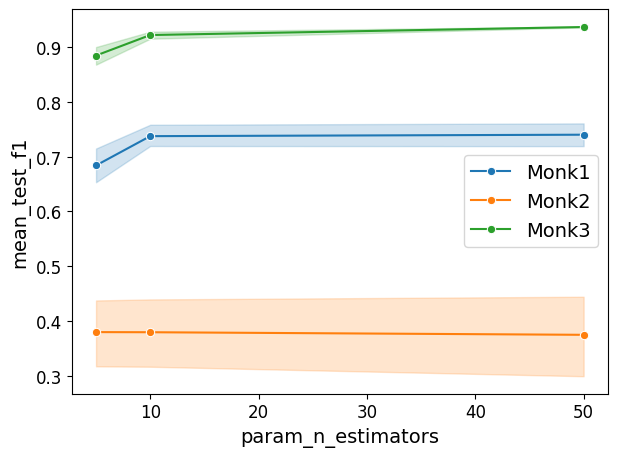

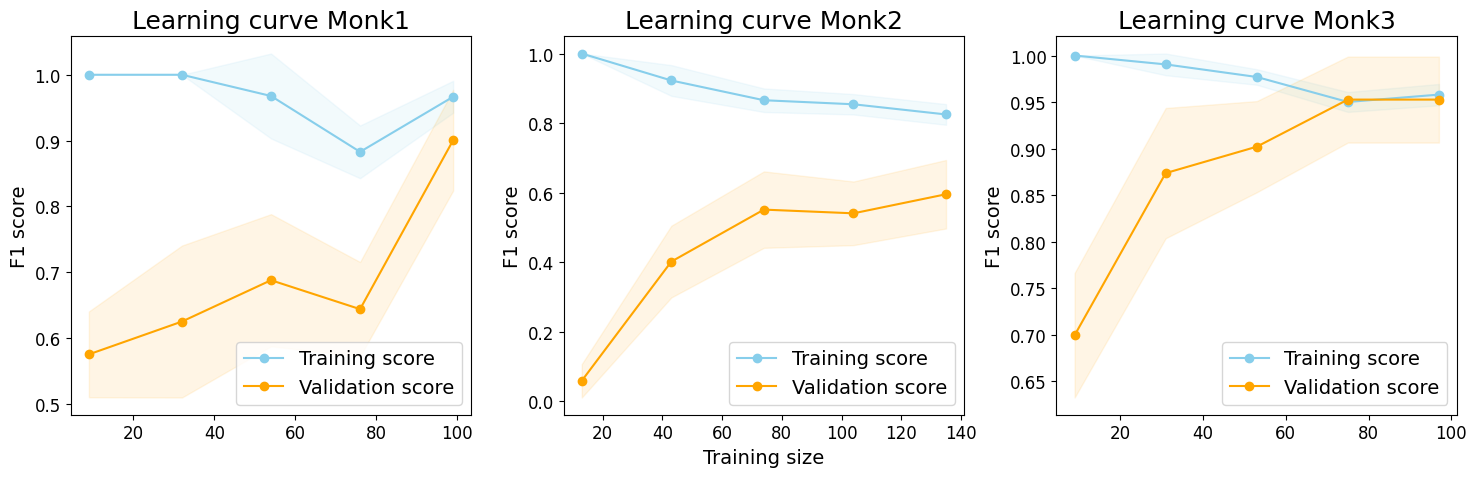

In [298]:
sns.lineplot(data=pd.DataFrame(extraMonk1.cv_results_), x='param_n_estimators', y='mean_test_f1', label='Monk1', marker='o')
sns.lineplot(data=pd.DataFrame(extraMonk2.cv_results_), x='param_n_estimators', y='mean_test_f1', label='Monk2', marker='o')
sns.lineplot(data=pd.DataFrame(extraMonk3.cv_results_), x='param_n_estimators', y='mean_test_f1', label='Monk3', marker='o')
plt.tight_layout()
plt.show()

fig3, ax3 = plt.subplots(1, 3, figsize=(15, 5))
train_sizes, train_scores, val_scores = learning_curve(extraMonk1.best_estimator_,
                                            monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[0].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[0].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[0].set_title('Learning curve Monk1')
# ax3[0].set_xlabel('Training size')
ax3[0].set_ylabel('F1 score')
ax3[0].legend()
train_sizes, train_scores, val_scores = learning_curve(extraMonk2.best_estimator_,
                                            monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[1].set_title('Learning curve Monk2')
ax3[1].set_xlabel('Training size')
ax3[1].set_ylabel('F1 score')
ax3[1].legend()
train_sizes, train_scores, val_scores = learning_curve(extraMonk3.best_estimator_,
                                            monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[2].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[2].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[2].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[2].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[2].set_title('Learning curve Monk3')
# ax3[2].set_xlabel('Training size')
ax3[2].set_ylabel('F1 score')
ax3[2].legend()
plt.tight_layout()
plt.show()

Non sembra molto diversa dalla random forest. Proceediamo osservando come varia l'F1-Score con il numero di alberi

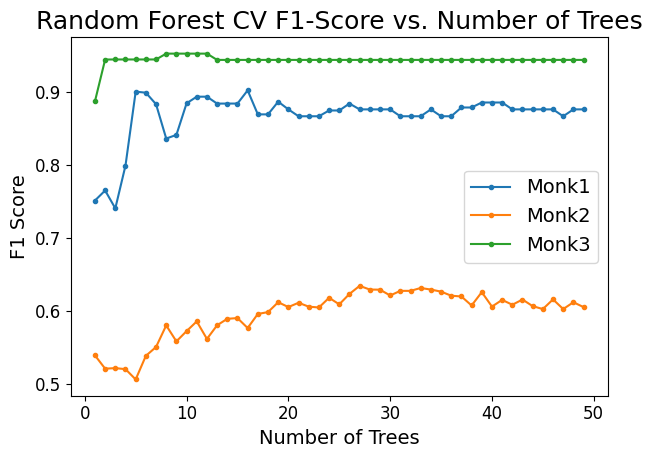

0.9023112668330059 16
0.6345574712643678 27
0.9526153846153846 8


In [ ]:
m1F1 = []
m2F1 = []
m3F1 = []
confMat1 = []
confMat2 = []
maxN = 50
param1 = extraMonk1.best_params_
param2 = extraMonk2.best_params_
param3 = extraMonk3.best_params_
del param1['n_estimators']
del param2['n_estimators']
del param3['n_estimators']

for n in range(1, maxN):
    rf_temp1 = ExtraTreesClassifier(n_estimators=n, **param1, random_state=42)
    rf_temp2 = ExtraTreesClassifier(n_estimators=n, **param2, random_state=42)
    rf_temp3 = ExtraTreesClassifier(n_estimators=n, **param3, random_state=42)
    rf_temp1.fit(monk1.featuresTrain, monk1.labelTrain)
    rf_temp2.fit(monk2.featuresTrain, monk2.labelTrain)
    rf_temp3.fit(monk3.featuresTrain, monk3.labelTrain)
    m1F1.append(np.mean(cross_val_score(rf_temp1, monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1')))
    m2F1.append(np.mean(cross_val_score(rf_temp2, monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1')))
    m3F1.append(np.mean(cross_val_score(rf_temp3, monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1')))
    

plt.plot(range(1, maxN), m1F1, label="Monk1", marker='.')
plt.plot(range(1, maxN), m2F1, label="Monk2", marker='.')
plt.plot(range(1, maxN), m3F1, label="Monk3", marker='.')
plt.legend()
plt.xlabel("Number of Trees")
plt.ylabel("F1 Score")
plt.title("Random Forest CV F1-Score vs. Number of Trees")
plt.tight_layout()
plt.show()

print(max(m1F1), np.argmax(m1F1)+1) # Parte da 1 quindi l'n-esimo elemento = n+1
print(max(m2F1), np.argmax(m2F1)+1)
print(max(m3F1), np.argmax(m3F1)+1)

c:\Program Files\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Monk1 best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'n_estimators': np.int64(16)}
Monk2 best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': np.int64(27)}
Monk3 best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'n_estimators': np.int64(8)}


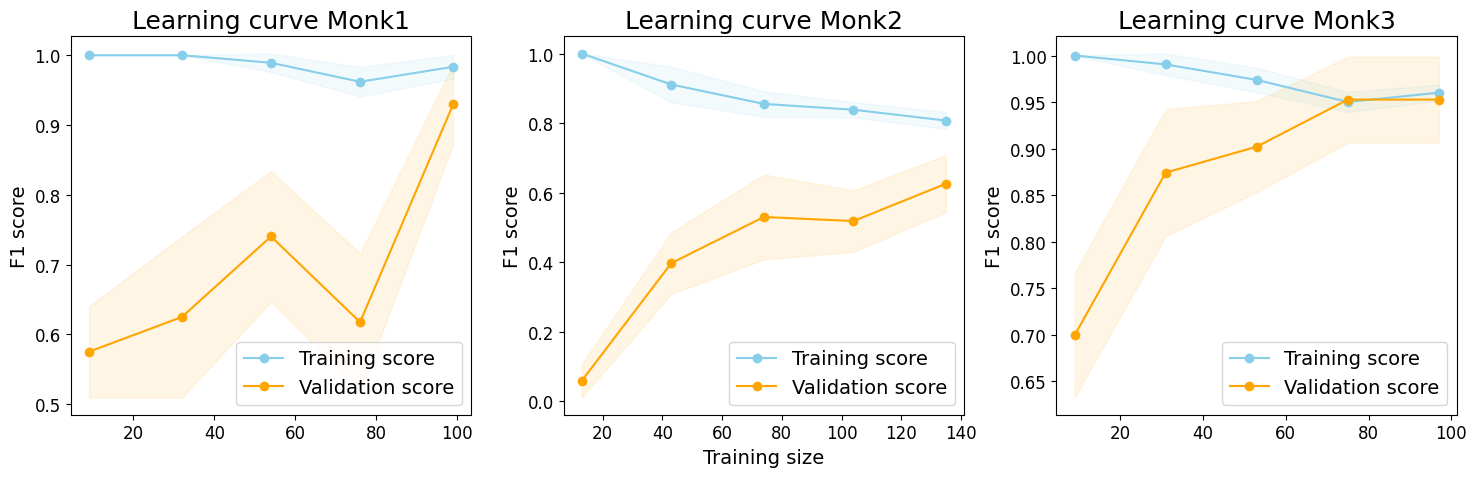

In [ ]:
parameters1 = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [np.argmax(m1F1)+1],
    'max_depth': [2, 3, 4],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

parameters2 = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [np.argmax(m2F1)+1],
    'max_depth': [2, 3, 4],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

parameters3 = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [np.argmax(m3F1)+1],
    'max_depth': [2, 3, 4],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

extraMonk1 = GridSearchCV(extra, parameters1, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
extraMonk2 = GridSearchCV(extra, parameters2, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')
extraMonk3 = GridSearchCV(extra, parameters3, cv=skf, n_jobs=-1, scoring=score, refit='f1', error_score='raise')

extraMonk1.fit(monk1.featuresTrain, monk1.labelTrain)
extraMonk2.fit(monk2.featuresTrain, monk2.labelTrain)
extraMonk3.fit(monk3.featuresTrain, monk3.labelTrain)

print(f"Monk1 best parameters: {extraMonk1.best_params_}")
print(f"Monk2 best parameters: {extraMonk2.best_params_}")
print(f"Monk3 best parameters: {extraMonk3.best_params_}")

fig3, ax3 = plt.subplots(1, 3, figsize=(15, 5))
train_sizes, train_scores, val_scores = learning_curve(extraMonk1.best_estimator_,
                                            monk1.featuresTrain, monk1.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[0].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[0].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[0].set_title('Learning curve Monk1')
# ax3[0].set_xlabel('Training size')
ax3[0].set_ylabel('F1 score')
ax3[0].legend()
train_sizes, train_scores, val_scores = learning_curve(extraMonk2.best_estimator_,
                                            monk2.featuresTrain, monk2.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[1].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[1].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[1].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[1].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[1].set_title('Learning curve Monk2')
ax3[1].set_xlabel('Training size')
ax3[1].set_ylabel('F1 score')
ax3[1].legend()
train_sizes, train_scores, val_scores = learning_curve(extraMonk3.best_estimator_,
                                            monk3.featuresTrain, monk3.labelTrain, cv=skf, scoring='f1', n_jobs=-1)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)
ax3[2].plot(train_sizes, train_mean, label='Training score', color='skyblue', marker='o')
ax3[2].plot(train_sizes, val_mean, label='Validation score', color='orange', marker='o')
ax3[2].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='skyblue', alpha=0.1)
ax3[2].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.1)
ax3[2].set_title('Learning curve Monk3')
# ax3[2].set_xlabel('Training size')
ax3[2].set_ylabel('F1 score')
ax3[2].legend()
plt.tight_layout()
plt.show()


Random Forest
Monk-1 score: 0.993
Monk-2 score: 0.574
Monk-3 score: 0.957


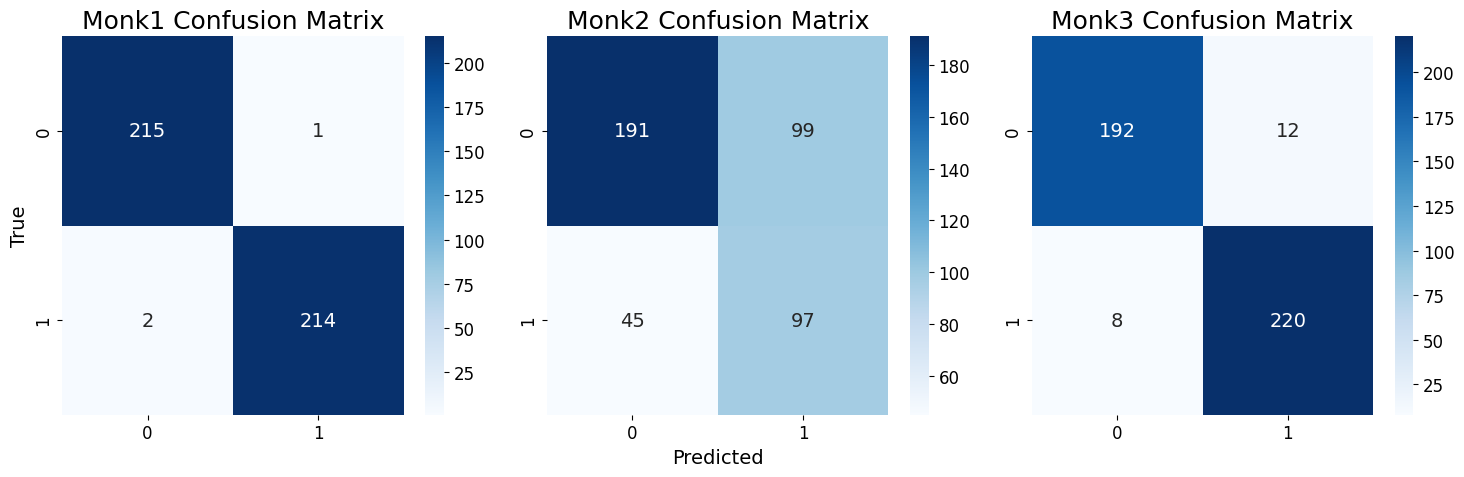

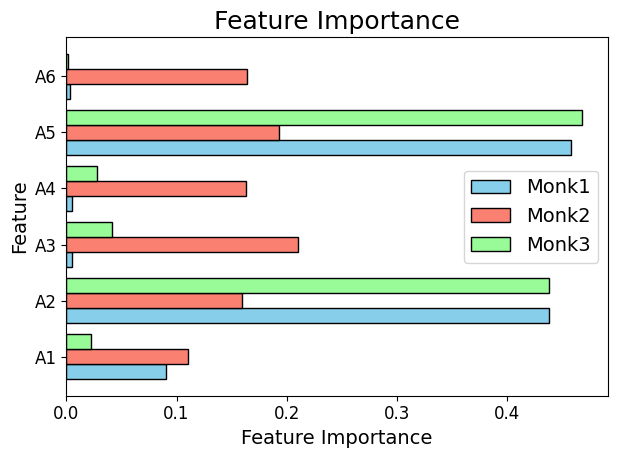

Classification Report Monk1
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       216
           1       1.00      0.99      0.99       216

    accuracy                           0.99       432
   macro avg       0.99      0.99      0.99       432
weighted avg       0.99      0.99      0.99       432

Classification Report Monk2
              precision    recall  f1-score   support

           0       0.81      0.66      0.73       290
           1       0.49      0.68      0.57       142

    accuracy                           0.67       432
   macro avg       0.65      0.67      0.65       432
weighted avg       0.71      0.67      0.68       432

Classification Report Monk3
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       204
           1       0.95      0.96      0.96       228

    accuracy                           0.95       432
   macro avg       0.95      0.95      0.95 

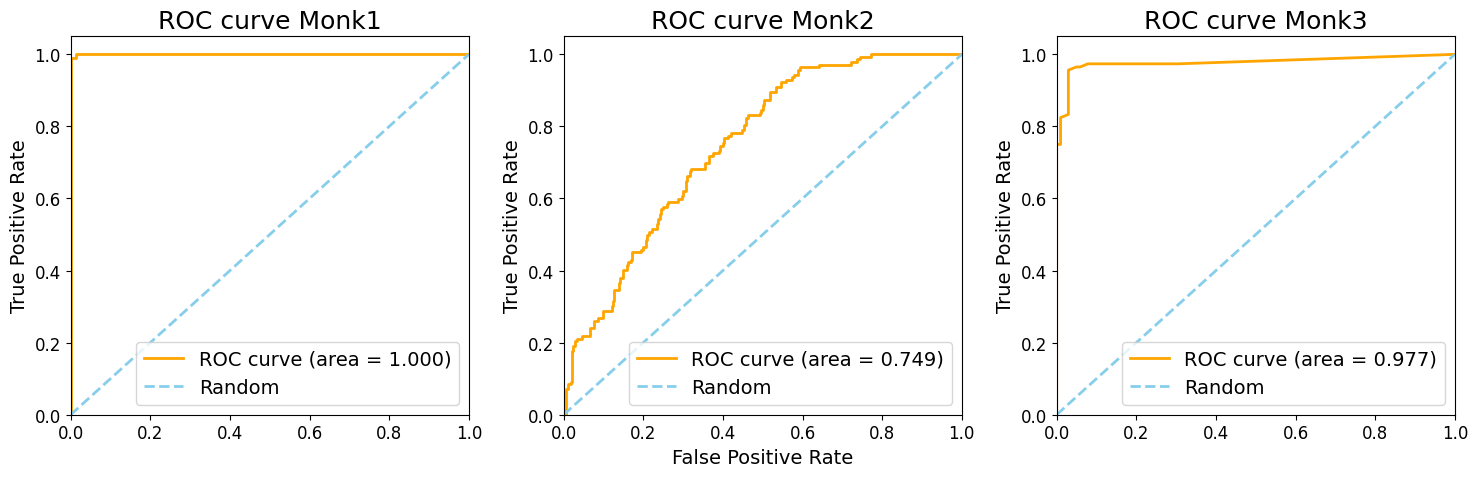

accuracy_score
0.9930555555555556
0.6666666666666666
0.9537037037037037
precision_score
0.9953488372093023
0.49489795918367346
0.9482758620689655


In [ ]:
extraMonk1Score = extraMonk1.score(monk1.featuresTest, monk1.labelTest)
extraMonk2Score = extraMonk2.score(monk2.featuresTest, monk2.labelTest)
extraMonk3Score = extraMonk3.score(monk3.featuresTest, monk3.labelTest)

print("\nRandom Forest")
print(f"Monk-1 score: {extraMonk1Score:.3f}")
print(f"Monk-2 score: {extraMonk2Score:.3f}")
print(f"Monk-3 score: {extraMonk3Score:.3f}")

fig1, ax1 = plt.subplots(1, 3, figsize=(15, 5))
confMatrixMonk1 = confusion_matrix(monk1.labelTest, extraMonk1.predict(monk1.featuresTest))
confMatrixMonk2 = confusion_matrix(monk2.labelTest, extraMonk2.predict(monk2.featuresTest))
confMatrixMonk3 = confusion_matrix(monk3.labelTest, extraMonk3.predict(monk3.featuresTest))
# print(confMatrixMonk1[0][1])
sns.heatmap(confMatrixMonk1, annot=True, fmt="d", cmap="Blues", ax=ax1[0])
sns.heatmap(confMatrixMonk2, annot=True, fmt="d", cmap="Blues", ax=ax1[1])
sns.heatmap(confMatrixMonk3, annot=True, fmt="d", cmap="Blues", ax=ax1[2])
ax1[0].set_title('Monk1 Confusion Matrix')
ax1[1].set_title('Monk2 Confusion Matrix')
ax1[2].set_title('Monk3 Confusion Matrix')
ax1[0].set(ylabel="True")
ax1[1].set(xlabel="Predicted")
plt.tight_layout()
plt.show()

monk1Feat = extraMonk1.best_estimator_.feature_importances_
monk2Feat = extraMonk2.best_estimator_.feature_importances_
monk3Feat = extraMonk3.best_estimator_.feature_importances_

x = np.arange(6)
width = 0.27

plt.barh(x - width, monk1Feat, height=width, label='Monk1', color='skyblue', edgecolor='black')
plt.barh(x, monk2Feat, height=width, label="Monk2", color='salmon', edgecolor='black')
plt.barh(x + width, monk3Feat, height=width, label="Monk3", color='palegreen', edgecolor='black')
plt.yticks(x, ['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.legend()
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

monk1CR = classification_report(monk1.labelTest, extraMonk1.predict(monk1.featuresTest))
monk2CR = classification_report(monk2.labelTest, extraMonk2.predict(monk2.featuresTest))
monk3CR = classification_report(monk3.labelTest, extraMonk3.predict(monk3.featuresTest))

print(f"Classification Report Monk1\n{monk1CR}")
print(f"Classification Report Monk2\n{monk2CR}")
print(f"Classification Report Monk3\n{monk3CR}")

fpr1, tpr1, thresholds1 = roc_curve(monk1.labelTest, extraMonk1.predict_proba(monk1.featuresTest)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(monk2.labelTest, extraMonk2.predict_proba(monk2.featuresTest)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(monk3.labelTest, extraMonk3.predict_proba(monk3.featuresTest)[:,1])
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

rocFig, rocax = plt.subplots(1, 3, figsize=(15, 5))
rocax[0].plot(fpr1, tpr1, lw=2, label=f'ROC curve (area = {roc_auc1:.3f})', color='orange')
rocax[0].plot([0, 1], [0, 1], lw=2, linestyle='--', color='skyblue', label='Random')
rocax[0].set_xlim([0.0, 1.0])
rocax[0].set_ylim([0.0, 1.05])
rocax[0].set_ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
rocax[0].set_title('ROC curve Monk1')
rocax[0].legend(loc="lower right")
rocax[1].plot(fpr2, tpr2, lw=2, label=f'ROC curve (area = {roc_auc2:.3f})', color='orange')
rocax[1].plot([0, 1], [0, 1], lw=2, linestyle='--', color='skyblue', label='Random')
rocax[1].set_xlim([0.0, 1.0])
rocax[1].set_ylim([0.0, 1.05])
rocax[1].set_ylabel('True Positive Rate')
rocax[1].set_xlabel('False Positive Rate')
rocax[1].set_title('ROC curve Monk2')
rocax[1].legend(loc="lower right")
rocax[2].plot(fpr3, tpr3, lw=2, label=f'ROC curve (area = {roc_auc3:.3f})', color='orange')
rocax[2].plot([0, 1], [0, 1], lw=2, linestyle='--', color='skyblue', label='Random')
rocax[2].set_xlim([0.0, 1.0])
rocax[2].set_ylim([0.0, 1.05])
rocax[2].set_ylabel('True Positive Rate')
rocax[2].legend(loc="lower right")
rocax[2].set_title('ROC curve Monk3')
plt.tight_layout()
plt.show()

print("accuracy_score")
print(accuracy_score(monk1.labelTest, extraMonk1.predict(monk1.featuresTest)))
print(accuracy_score(monk2.labelTest, extraMonk2.predict(monk2.featuresTest)))
print(accuracy_score(monk3.labelTest, extraMonk3.predict(monk3.featuresTest)))

print("precision_score")
print(precision_score(monk1.labelTest, extraMonk1.predict(monk1.featuresTest)))
print(precision_score(monk2.labelTest, extraMonk2.predict(monk2.featuresTest)))
print(precision_score(monk3.labelTest, extraMonk3.predict(monk3.featuresTest)))

I risultati sono piuttosto simili alla random forest